In [1]:
from datetime import datetime
import datetime as dt
import time
from subgrounds.subgraph import SyntheticField, FieldPath
from subgrounds.subgrounds import Subgrounds
import pandas as pd
import duckdb as db
import seaborn as sns
import matplotlib.pyplot as plt
import IPython as ip
import  os as os


In [2]:
sg = Subgrounds()
apiKey = input('API Key, please')

In [3]:
#for when we save the files
file = input('Selet a folder to save output') ##enter your file path here - the file is in the repo "summary_stats.csv".
file = file+'/data'
if not os.path.exists(file):
    os.makedirs(file)

*******************************************************************
*******************************************************************
LET'S LOOK AT SILO BORROWS FIRST
https://app.silo.finance/silo/0xc413dd03555f3eb29d834b482d386b2999dc2eb0

In [4]:
#SILO subgraph: https://gateway.thegraph.com/api/[api-key]/subgraphs/id/6rcT2GzBXGoi3ZMus92LHajM2b9qWGj7Z3dDhPxoUogB
silo = sg.load_api('https://gateway.thegraph.com/api/'+apiKey+'/subgraphs/id/6rcT2GzBXGoi3ZMus92LHajM2b9qWGj7Z3dDhPxoUogB')

In [5]:
oldBorrowsDb = pd.DataFrame()
siloFileName = file+'/siloFinance_borrows.csv'
try:
    oldBorrowsDb = pd.read_csv (siloFileName)
except:
    oldBorrowsDb = pd.DataFrame()
oldBorrowsDb.head(100)

""


In [6]:
maxSiloBorrowTimestamp = 0
try:
    maxSiloBorrowTimestamp = (max(0,oldBorrowsDb['transaction_timestamp'].max()))-5
except:
        maxSiloBorrowTimestamp = 0
maxSiloBorrowTimestamp = int(maxSiloBorrowTimestamp)
maxSiloBorrowTimestamp

0

In [66]:
##this captures the ENTIRE list of people who borrowed XAI against gOHM
borrowTicker = 0
borrowslist = pd.DataFrame()
borrowsDb = pd.DataFrame()
borrowListLength = 1000
datediff = 0
now=0
daysAgo=0
daysLimit = 45
exit = False
while exit==False:
    skipValue = (borrowTicker)*(1000)
    borrows = silo.Query.borrows(
        orderBy='timestamp',
        orderDirection='desc',
        first=1000,
        skip = skipValue,
        where={ 'market': '0xc413dd03555f3eb29d834b482d386b2999dc2eb0',
                'timestamp_gte': maxSiloBorrowTimestamp
                } #gOHM market

    )

    borrowslist = sg.query_df([
        borrows.id
        ,borrows.hash
        ,borrows.blockNumber
        ,borrows.timestamp
        ,borrows.account.id
        ,borrows.market.id
        ,borrows.market.protocol.id
        ,borrows.market.rates.rate
        ,borrows.market.rates.duration
        ,borrows.market.rates.side
        ,borrows.market.rates.type
        ,borrows.market.rates.token.id
        ,borrows.asset.name
        ,borrows.asset.symbol
        ,borrows.asset.decimals
        ,borrows.asset.lastPriceUSD
        ,borrows.amount
        ,borrows.amountUSD
    ])

    #borrowslist.sort_values(by=['borrows_timestamp'])

    borrowsDb=pd.concat([borrowsDb, borrowslist])
    recordTimestamp1 = borrowsDb.iat[borrowTicker,3]
    recordTimestamp = dt.datetime.fromtimestamp( recordTimestamp1 )
    now = (int(dt.datetime.utcnow().timestamp()))
    datediff=abs(int(now) - recordTimestamp1)
    daysAgo = int(datediff/86400)
    borrowsDbLength = len(borrowsDb)
    borrowListLength = len(borrowslist)
    recordID = borrowsDb.iat[borrowTicker,0]
    borrow = borrowsDb.iat[borrowTicker,1]
    print("iterations: ", borrowTicker, "Lines skipped: ",skipValue, "records collected: ", borrowListLength, " - latest recordID: ",borrow, " ", recordID , " - borrows DB length: ", borrowsDbLength, " - latest record from: ", recordTimestamp, daysAgo,"days ago")
    #print("iterations: ", borrowTicker, "records collected: ", borrowListLength, " - userdb length: ", borrowsDbLength)
    borrowTicker = borrowTicker+1

    if daysAgo>daysLimit: exit =True
    if borrowListLength<1000: exit =True

borrowsDb.columns = borrowsDb.columns.str.replace("borrows", "transaction")
borrowsDb['event']='borrow'
borrowsDb.drop_duplicates
print("Done. Total Records collected: ", borrowsDbLength)

iterations:  0 Lines skipped:  0 records collected:  1998  - latest recordID:  0xccb7b4f00f58ea66194c868a8d0dfbc35816b965da27f70941fd16a318fd8638   0xccb7b4f00f58ea66194c868a8d0dfbc35816b965da27f70941fd16a318fd8638-228  - borrows DB length:  1998  - latest record from:  2023-02-25 04:10:47 0 days ago
iterations:  1 Lines skipped:  1000 records collected:  0  - latest recordID:  0xccb7b4f00f58ea66194c868a8d0dfbc35816b965da27f70941fd16a318fd8638   0xccb7b4f00f58ea66194c868a8d0dfbc35816b965da27f70941fd16a318fd8638-228  - borrows DB length:  1998  - latest record from:  2023-02-25 04:10:47 0 days ago
Done. Total Records collected:  1998


In [67]:
borrowsDb.head(100)

,transaction_id,transaction_hash,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_market_id,transaction_market_protocol_id,transaction_market_rates_rate,transaction_market_rates_duration,transaction_market_rates_side,transaction_market_rates_type,transaction_market_rates_token_id,transaction_asset_name,transaction_asset_symbol,transaction_asset_decimals,transaction_asset_lastPriceUSD,transaction_amount,transaction_amountUSD,event
0,0xccb7b4f00f58ea66194c868a8d0dfbc35816b965da27...,0xccb7b4f00f58ea66194c868a8d0dfbc35816b965da27...,16705210,1677327047,0xd49a92e7b6b0cb702f4cfb35c2502c08f26ef62e,0xac3333401e69574d433307b31f43a7826eb6f8fd,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,None,BORROWER,VARIABLE,0x4a220e6096b25eadb88358cb44068a3248254675,XAI Stablecoin,XAI,18,1.006361,3300000000000000000000,3317.807830,borrow
1,0xccb7b4f00f58ea66194c868a8d0dfbc35816b965da27...,0xccb7b4f00f58ea66194c868a8d0dfbc35816b965da27...,16705210,1677327047,0xd49a92e7b6b0cb702f4cfb35c2502c08f26ef62e,0xac3333401e69574d433307b31f43a7826eb6f8fd,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,None,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,1.006361,3300000000000000000000,3317.807830,borrow
2,0xccb7b4f00f58ea66194c868a8d0dfbc35816b965da27...,0xccb7b4f00f58ea66194c868a8d0dfbc35816b965da27...,16705210,1677327047,0xd49a92e7b6b0cb702f4cfb35c2502c08f26ef62e,0xac3333401e69574d433307b31f43a7826eb6f8fd,0xd998c35b7900b344bbbe6555cc11576942cf309d,3.457274,None,BORROWER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,XAI Stablecoin,XAI,18,1.006361,3300000000000000000000,3317.807830,borrow
3,0xccb7b4f00f58ea66194c868a8d0dfbc35816b965da27...,0xccb7b4f00f58ea66194c868a8d0dfbc35816b965da27...,16705210,1677327047,0xd49a92e7b6b0cb702f4cfb35c2502c08f26ef62e,0xac3333401e69574d433307b31f43a7826eb6f8fd,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,None,LENDER,VARIABLE,0x4a220e6096b25eadb88358cb44068a3248254675,XAI Stablecoin,XAI,18,1.006361,3300000000000000000000,3317.807830,borrow
4,0xccb7b4f00f58ea66194c868a8d0dfbc35816b965da27...,0xccb7b4f00f58ea66194c868a8d0dfbc35816b965da27...,16705210,1677327047,0xd49a92e7b6b0cb702f4cfb35c2502c08f26ef62e,0xac3333401e69574d433307b31f43a7826eb6f8fd,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,None,LENDER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,1.006361,3300000000000000000000,3317.807830,borrow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0x264ecb6cc9089ebf8fcb6f8ae5ce26358b15b0551e61...,0x264ecb6cc9089ebf8fcb6f8ae5ce26358b15b0551e61...,16648400,1676636519,0xcb6e1613029d790c00f89296808f278d6dc25b2f,0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.943749,None,LENDER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,Olympus,OHM,9,10.368667,58000000000,615.628222,borrow
96,0x65ddba01deef5ba9df8f48c688b1bcca63ceb6255e5c...,0x65ddba01deef5ba9df8f48c688b1bcca63ceb6255e5c...,16647257,1676622563,0xf3fcaba0702b49c33664058ed6dc745ed6d393f1,0xac3333401e69574d433307b31f43a7826eb6f8fd,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,None,BORROWER,VARIABLE,0x4a220e6096b25eadb88358cb44068a3248254675,XAI Stablecoin,XAI,18,1.006361,50000000000000000000000,50138.456850,borrow
97,0x65ddba01deef5ba9df8f48c688b1bcca63ceb6255e5c...,0x65ddba01deef5ba9df8f48c688b1bcca63ceb6255e5c...,16647257,1676622563,0xf3fcaba0702b49c33664058ed6dc745ed6d393f1,0xac3333401e69574d433307b31f43a7826eb6f8fd,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,None,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,1.006361,50000000000000000000000,50138.456850,borrow
98,0x65ddba01deef5ba9df8f48c688b1bcca63ceb6255e5c...,0x65ddba01deef5ba9df8f48c688b1bcca63ceb6255e5c...,16647257,1676622563,0xf3fcaba0702b49c33664058ed6dc745ed6d393f1,0xac3333401e69574d433307b31f43a7826eb6f8fd,0xd998c35b7900b344bbbe6555cc11576942cf309d,3.457274,None,BORROWER,VARIA

In [9]:
#I swear I will figure out synthetic fields, but until then...
borrowsDbTimed = db.query("select "
               "    * "
                    " ,to_timestamp(transaction_timestamp::int) dateTime "
               "From borrowsDb "
                      "order by transaction_amountUSD desc"
               #"where lower(liquidityPools_name) like lower('%olympus%') "
                #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
               #" limit 100 "
               ).df()
borrowsDbTimed.head(100)

,transaction_id,transaction_hash,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_market_id,transaction_market_protocol_id,transaction_market_rates_rate,transaction_market_rates_duration,transaction_market_rates_side,transaction_market_rates_type,transaction_market_rates_token_id,transaction_asset_name,transaction_asset_symbol,transaction_asset_decimals,transaction_asset_lastPriceUSD,transaction_amount,transaction_amountUSD,event,dateTime
0,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,1.005034,186000000000000000000000,185996.147731,borrow,2023-02-09 06:23:59
1,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,11.352275,NaN,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,1.005034,186000000000000000000000,185996.147731,borrow,2023-02-09 06:23:59
2,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,3.411870,NaN,BORROWER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,XAI Stablecoin,XAI,18,1.005034,186000000000000000000000,185996.147731,borrow,2023-02-09 06:23:59
3,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,LENDER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,1.005034,186000000000000000000000,185996.147731,borrow,2023-02-09 06:23:59
4,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,8.722231,NaN,LENDER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,1.005034,186000000000000000000000,185996.147731,borrow,2023-02-09 06:23:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0x30c76353a03ffe6931799da8b7439b1fcb02c3952f54...,0x30c76353a03ffe6931799da8b7439b1fcb02c3952f54...,16533360,1675247171,0x339fd7c17ce670e7821f2f2ee94ddd49771483da,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,2.328203,NaN,LENDER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,XAI Stablecoin,XAI,18,1.005034,5000000000000000000000,5001.341848,borrow,2023-02-01 10:26:11
96,0x5946a769e10307668b4b60aa3b36d5189916cc02fc23...,0x5946a769e10307668b4b60aa3b36d5189916cc02fc23...,16684007,1677069179,0x5656cb4721c21e1f5dcbe03db9026ac0203d6e4f,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,1.005034,4520000000000000000000,4510.003371,borrow,2023-02-22 12:32:59
97,0x5946a769e10307668b4b60aa3b36d5189916cc02fc23...,0x5946a769e10307668b4b60aa3b36d5189916cc02fc23...,16684007,1677069179,0x5656cb4721c21e1f5dcbe03db9026ac0203d6e4f,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,11.352275,NaN,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,1.005034,4520000000000000000000,4510.003371,borrow,2023-02-22 12:32:59
98,0x5946a769e10307668b4b60aa3b36d5189916cc02fc23...,0x5946a769e10307668b4b60a

In [10]:
borrowsDbTimed = pd.concat([oldBorrowsDb,borrowsDbTimed]).drop_duplicates().reset_index(drop=True)
borrowsDbTimed.drop_duplicates()
borrowsDbTimed = db.query("select "
               "    * "
               "From borrowsDbTimed "
                         "group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20 "
                      "order by transaction_amountUSD desc "
               #"where lower(liquidityPools_name) like lower('%olympus%') "
                #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
               #" limit 100 "
               ).df()

borrowsDbTimed.head(100)

,transaction_id,transaction_hash,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_market_id,transaction_market_protocol_id,transaction_market_rates_rate,transaction_market_rates_duration,transaction_market_rates_side,transaction_market_rates_type,transaction_market_rates_token_id,transaction_asset_name,transaction_asset_symbol,transaction_asset_decimals,transaction_asset_lastPriceUSD,transaction_amount,transaction_amountUSD,event,dateTime
0,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,1.005034,186000000000000000000000,185996.147731,borrow,2023-02-09 06:23:59
1,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,11.352275,NaN,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,1.005034,186000000000000000000000,185996.147731,borrow,2023-02-09 06:23:59
2,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,3.411870,NaN,BORROWER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,XAI Stablecoin,XAI,18,1.005034,186000000000000000000000,185996.147731,borrow,2023-02-09 06:23:59
3,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,LENDER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,1.005034,186000000000000000000000,185996.147731,borrow,2023-02-09 06:23:59
4,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,8.722231,NaN,LENDER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,1.005034,186000000000000000000000,185996.147731,borrow,2023-02-09 06:23:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0x30c76353a03ffe6931799da8b7439b1fcb02c3952f54...,0x30c76353a03ffe6931799da8b7439b1fcb02c3952f54...,16533360,1675247171,0x339fd7c17ce670e7821f2f2ee94ddd49771483da,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,1.005034,5000000000000000000000,5001.341848,borrow,2023-02-01 10:26:11
96,0x5946a769e10307668b4b60aa3b36d5189916cc02fc23...,0x5946a769e10307668b4b60aa3b36d5189916cc02fc23...,16684007,1677069179,0x5656cb4721c21e1f5dcbe03db9026ac0203d6e4f,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,1.005034,4520000000000000000000,4510.003371,borrow,2023-02-22 12:32:59
97,0x5946a769e10307668b4b60aa3b36d5189916cc02fc23...,0x5946a769e10307668b4b60aa3b36d5189916cc02fc23...,16684007,1677069179,0x5656cb4721c21e1f5dcbe03db9026ac0203d6e4f,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,11.352275,NaN,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,1.005034,4520000000000000000000,4510.003371,borrow,2023-02-22 12:32:59
98,0x5946a769e10307668b4b60aa3b36d5189916cc02fc23...,0x5946a769e10307668b4b6

In [11]:
siloBorrowEventsDbTimedClean = db.query("select "
                            " transaction_id"
                            " ,event "
                            ", transaction_hash "
                            ", transaction_blockNumber "
                            ", transaction_timestamp "
                            ", transaction_account_id "
                            ", transaction_market_id "
                            ", transaction_asset_name "
                            ", transaction_asset_symbol "
                            ", transaction_amount "
                            ", (transaction_amount::hugeint*1e-17) transactionReadableAmount "
                            ", transaction_amountUSD "
                            ", dateTime "
                            ", date_trunc('day', dateTime) calDate "
               "From borrowsDbTimed "
                         "group by"
                            " transaction_id"
                            " ,event "
                            ", transaction_hash "
                            ", transaction_blockNumber "
                            ", transaction_timestamp "
                            ", transaction_account_id "
                            ", transaction_market_id "
                            ", transaction_asset_name "
                            ", transaction_asset_symbol "
                            ", transaction_amount "
                            ", transaction_amountUSD "
                            ", dateTime "
                      "order by transaction_amountUSD desc "
               #"where lower(liquidityPools_name) like lower('%olympus%') "
                #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
               #" limit 100 "
               ).df()
siloBorrowEventsDbTimedClean.head(100)

,transaction_id,event,transaction_hash,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_market_id,transaction_asset_name,transaction_asset_symbol,transaction_amount,transactionReadableAmount,transaction_amountUSD,dateTime,calDate
0,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,borrow,0x16f2ff52f7a9e9057848569ea37c3e59eb558af0e044...,16589389,1675923839,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,XAI Stablecoin,XAI,186000000000000000000000,1.860000e+06,185996.147731,2023-02-09 06:23:59,2023-02-09
1,0x3b0f26e10c63a71c916e8a68bd1889d9bab38aeb62d7...,borrow,0x3b0f26e10c63a71c916e8a68bd1889d9bab38aeb62d7...,16641746,1676556011,0xee95e4cf086fc80df7ae0f39dfc9ea53a3eaadcb,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,XAI Stablecoin,XAI,100000000000000000000000,1.000000e+06,100012.487283,2023-02-16 14:00:11,2023-02-16
2,0x3dba2dd3c913b399164efd71db73121c9c94c0096139...,borrow,0x3dba2dd3c913b399164efd71db73121c9c94c0096139...,16622907,1676328371,0x46535cbc3fa574c32ea392d4f89c518290597072,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,Governance OHM,gOHM,26400000000000000000,2.640000e+02,71910.521424,2023-02-13 22:46:11,2023-02-13
3,0x66fe10ed6dcb8b83bdb5b0c46cd321060734b9063bd5...,borrow,0x66fe10ed6dcb8b83bdb5b0c46cd321060734b9063bd5...,16651434,1676673563,0xd33e76d21d32c21811593ae54e38f68df0cfe8ed,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,XAI Stablecoin,XAI,60500000000000000000000,6.050000e+05,59947.550425,2023-02-17 22:39:23,2023-02-17
4,0x072c04ee8776ea91e8c1003bad2d401e3ac90d0ab2fc...,borrow,0x072c04ee8776ea91e8c1003bad2d401e3ac90d0ab2fc...,16579820,1675808183,0x0493bcca897a2248ae3cd4c66aea90dbfc7e13c6,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,XAI Stablecoin,XAI,30000000000000000000000,3.000000e+05,29884.417447,2023-02-07 22:16:23,2023-02-07
5,0xb38cef69963653bc8f3e04720bd0d3f3df6e6e9ede13...,borrow,0xb38cef69963653bc8f3e04720bd0d3f3df6e6e9ede13...,16573202,1675728155,0x36125234dd6c7d0a01dcadc67e79e061d405098e,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,XAI Stablecoin,XAI,25000000000000000000000,2.500000e+05,24937.155253,2023-02-07 00:02:35,2023-02-07
6,0x38ce8e39e188c85ba03a340cdde95c2e1d56b54161e6...,borrow,0x38ce8e39e188c85ba03a340cdde95c2e1d56b54161e6...,16579819,1675808171,0x96035b45bc0d22f0ed11283a91145fb001c48370,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,XAI Stablecoin,XAI,20000000000000000000000,2.000000e+05,19922.944964,2023-02-07 22:16:11,2023-02-07
7,0x7a9527e13f7627c09cc9bdcc43d1aa6a7babf0c087b8...,borrow,0x7a9527e13f7627c09cc9bdcc43d1aa6a7babf0c087b8...,16681973,1677044447,0x7aaee144a14ec3ba0e468c9dcf4a89fdb62c5aa6,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,XAI Stablecoin,XAI,16500000000000000000000,1.650000e+05,16472.437498,2023-02-22 05:40:47,2023-02-22
8,0x2485acd5a3853dc50921a27ea5bf8227871425cca3e4...,borrow,0x2485acd5a3853dc50921a27ea5bf8227871425cca3e4...,16171818,1670886647,0x1ba67f30e25fc43863b50047d7fd4bd63b9c59ec,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,XAI Stablecoin,XAI,11900000000000000000000,1.190000e+05,11928.568949,2022-12-12 23:10:47,2022-12-12
9,0xe034b0dedaea9ad1f849d5420228106937d816b89b3a...,borrow,0xe034b0dedaea9ad1f849d5420228106937d816b89b3a...,16505284,1674908519,0x42daeb9ca091e3933c8ee93c029701b926b1f336,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,XAI Stablecoin,XAI,10000000000000000000000,1.000000e+05,10040.961438,2023-01-28 12:21:59,2023-01-28


In [12]:
path =file+'/siloFinance_borrows.csv'
siloBorrowEventsDbTimedClean.to_csv(path, index = False)

path =file+'/siloFinance_borrows_piped.csv'
siloBorrowEventsDbTimedClean.to_csv(path, index = False, sep='|')
print(path, 'file saved,', len(borrowsDbTimed),' records')

D:\Dropbox\Documents\Edgecaser LLC\Projects\Olympus\Econohmetrics\gohmAsStablecoinCollateral/data/siloFinance_borrows_piped.csv file saved, 180  records


In [13]:
totalBorrowed = sum(siloBorrowEventsDbTimedClean['transactionReadableAmount'])
print('There has been a total of',round(totalBorrowed,2),  'OHM borrowed cumulatively to date')

There has been a total of 5167302.54 OHM borrowed cumulatively to date


[Text(0.5, 1.0, 'OHM borrowed per day'), Text(0.5, 0, 'Date'), Text(0, 0.5, 'OHM')]


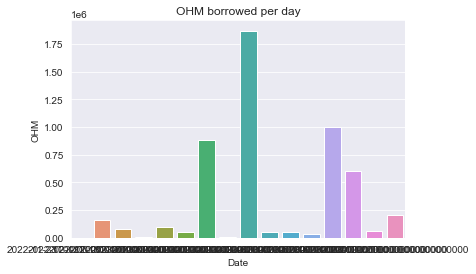

In [14]:
plt.rc("figure", figsize=(80, 40))
#sns.set_style("whitegrid")
plt.rc("font", size=50)


value_locked = siloBorrowEventsDbTimedClean.groupby("calDate")["transactionReadableAmount"].agg("sum").reset_index()
plot_title = 'OHM borrowed per day'
chart=sns.barplot(data=value_locked,y="transactionReadableAmount",x="calDate").set(title = plot_title, xlabel = 'Date', ylabel = 'OHM', )
print(chart)

********************************************************************************************
********************************************************************************************
Silo Repays

In [15]:
oldRepaysDb = pd.DataFrame()
siloFileName = file+'/siloFinance_repays.csv'
try:
    oldRepaysDb = pd.read_csv (siloFileName)
except:
    oldRepaysDb = pd.DataFrame()
oldRepaysDb.head(100)

""


In [16]:
maxRepaySiloTimestamp = 0
try:
    maxRepaySiloTimestamp = (max(1,oldRepaysDb['transaction_timestamp'].max()))-5
except:
        maxRepaySiloTimestamp = 0
maxRepaySiloTimestamp = int(maxRepaySiloTimestamp)
maxRepaySiloTimestamp

0

In [17]:
##this tracks the ENTIRE list of events for repaying the XAI repayed against gOHM
repayTicker = 0
repayslist = pd.DataFrame()
repaysDb = pd.DataFrame()
repayListLength = 1000
datediff = 0
now=0
daysAgo=0
daysLimit = 45
exit = False
while exit==False:
    skipValue = (repayTicker)*(1000)
    repays = silo.Query.repays(
        orderBy='timestamp',
        orderDirection='desc',
        first=1000,
        skip = skipValue,
        where={ 'market': '0xc413dd03555f3eb29d834b482d386b2999dc2eb0'  #gOHM market
                ,'timestamp_gte': maxRepaySiloTimestamp
                } #gOHM market

    )

    repayslist = sg.query_df([
        repays.id
        ,repays.hash
        ,repays.blockNumber
        ,repays.timestamp
        ,repays.account.id
        ,repays.market.id
        ,repays.market.protocol.id
        ,repays.market.rates.rate
        ,repays.market.rates.duration
        ,repays.market.rates.side
        ,repays.market.rates.type
        ,repays.market.rates.token.id
        ,repays.asset.name
        ,repays.asset.symbol
        ,repays.asset.decimals
        ,repays.asset.lastPriceUSD
        ,repays.amount
        ,repays.amountUSD
    ])

    #repayslist.sort_values(by=['repays_timestamp'])

    repaysDb=pd.concat([repaysDb, repayslist])
    recordTimestamp1 = repaysDb.iat[repayTicker,3]
    recordTimestamp = dt.datetime.fromtimestamp( recordTimestamp1 )
    now = (int(dt.datetime.utcnow().timestamp()))
    datediff=abs(int(now) - recordTimestamp1)
    daysAgo = int(datediff/86400)
    repaysDbLength = len(repaysDb)
    repayListLength = len(repayslist)
    recordID = repaysDb.iat[repayTicker,0]
    repay = repaysDb.iat[repayTicker,1]
    print("iterations: ", repayTicker, "Lines skipped: ",skipValue, "records collected: ", repayListLength, " - latest recordID: ",repay, " ", recordID , " - repays DB length: ", repaysDbLength, " - latest record from: ", recordTimestamp, daysAgo,"days ago")
    #print("iterations: ", repayTicker, "records collected: ", repayListLength, " - userdb length: ", repaysDbLength)
    repayTicker = repayTicker+1

    if daysAgo>daysLimit: exit =True
    if repayListLength<1000: exit =True

repaysDb.columns = repaysDb.columns.str.replace("repays", "transaction")
repaysDb['event']='repay'
repaysDb.drop_duplicates()
print("Done. Total Records collected: ", repaysDbLength)

iterations:  0 Lines skipped:  0 records collected:  42  - latest recordID:  0x038790f93d972fc6a3542036d9e615be7c3eb1252013bc4b5a45d5e24f503511   0x038790f93d972fc6a3542036d9e615be7c3eb1252013bc4b5a45d5e24f503511-229  - repays DB length:  42  - latest record from:  2023-02-15 07:27:11 8 days ago
Done. Total Records collected:  42


In [18]:
#I swear I will figure out synthetic fields, but until then...
repaysDbDbTimed = db.query("select "
               "    * "
                    " ,to_timestamp(transaction_timestamp::int) dateTime "
               "From repaysDb "
                      "order by transaction_amountUSD desc"
               #"where lower(liquidityPools_name) like lower('%olympus%') "
                #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
               #" limit 100 "
               ).df()
repaysDbDbTimed.head(100)

,transaction_id,transaction_hash,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_market_id,transaction_market_protocol_id,transaction_market_rates_rate,transaction_market_rates_duration,transaction_market_rates_side,transaction_market_rates_type,transaction_market_rates_token_id,transaction_asset_name,transaction_asset_symbol,transaction_asset_decimals,transaction_asset_lastPriceUSD,transaction_amount,transaction_amountUSD,event,dateTime
0,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,16628154,1676391755,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,1.005034,100000000000000000000000,100169.938162,repay,2023-02-14 16:22:35
1,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,16628154,1676391755,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,11.352275,NaN,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,1.005034,100000000000000000000000,100169.938162,repay,2023-02-14 16:22:35
2,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,16628154,1676391755,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,3.411870,NaN,BORROWER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,XAI Stablecoin,XAI,18,1.005034,100000000000000000000000,100169.938162,repay,2023-02-14 16:22:35
3,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,16628154,1676391755,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,LENDER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,1.005034,100000000000000000000000,100169.938162,repay,2023-02-14 16:22:35
4,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,16628154,1676391755,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,8.722231,NaN,LENDER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,1.005034,100000000000000000000000,100169.938162,repay,2023-02-14 16:22:35
5,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,16628154,1676391755,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,2.328203,NaN,LENDER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,XAI Stablecoin,XAI,18,1.005034,100000000000000000000000,100169.938162,repay,2023-02-14 16:22:35
6,0xcd3894d9378da63ad37be32ec959973c5b171dc8c285...,0xcd3894d9378da63ad37be32ec959973c5b171dc8c285...,16634833,1676472467,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,1.005034,86097742961225053188537,86762.218165,repay,2023-02-15 14:47:47
7,0xcd3894d9378da63ad37be32ec959973c5b171dc8c285...,0xcd3894d9378da63ad37be32ec959973c5b171dc8c285...,16634833,1676472467,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,11.352275,NaN,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,1.005034,86097742961225053188537,86762.218165,repay,2023-02-15 14:47:47
8,0xcd3894d9378da63ad37be32ec959973c5b171dc8c285...,0xcd3894d9378da63ad37be32ec959973c5b171dc8c285...,16634833,1676472467,0xb0399dac8f4d4100b49b2a7b3873481114229d18,

Why the heck do I see several interest rates for the same txn?

In [19]:
repaysDbTimed = pd.concat([oldRepaysDb,repaysDbDbTimed]).drop_duplicates().reset_index(drop=True)
repaysDbTimed.sort_values(['transaction_id','transaction_market_rates_rate'])
repaysDbTimed.drop_duplicates(keep='first' )

repaysDbTimed = db.query("select "
               "    * "
               "From repaysDbDbTimed "
                         "group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20 "
                      "order by transaction_amountUSD desc "
               #"where lower(liquidityPools_name) like lower('%olympus%') "
                #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
               #" limit 100 "
               ).df()


repaysDbTimed.head(100)

,transaction_id,transaction_hash,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_market_id,transaction_market_protocol_id,transaction_market_rates_rate,transaction_market_rates_duration,transaction_market_rates_side,transaction_market_rates_type,transaction_market_rates_token_id,transaction_asset_name,transaction_asset_symbol,transaction_asset_decimals,transaction_asset_lastPriceUSD,transaction_amount,transaction_amountUSD,event,dateTime
0,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,16628154,1676391755,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,1.005034,100000000000000000000000,100169.938162,repay,2023-02-14 16:22:35
1,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,16628154,1676391755,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,11.352275,NaN,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,1.005034,100000000000000000000000,100169.938162,repay,2023-02-14 16:22:35
2,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,16628154,1676391755,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,3.411870,NaN,BORROWER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,XAI Stablecoin,XAI,18,1.005034,100000000000000000000000,100169.938162,repay,2023-02-14 16:22:35
3,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,16628154,1676391755,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,LENDER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,1.005034,100000000000000000000000,100169.938162,repay,2023-02-14 16:22:35
4,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,16628154,1676391755,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,8.722231,NaN,LENDER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,1.005034,100000000000000000000000,100169.938162,repay,2023-02-14 16:22:35
5,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,0xfb97f8e2544f2063f69249a0ba2138b8272c34596661...,16628154,1676391755,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,2.328203,NaN,LENDER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,XAI Stablecoin,XAI,18,1.005034,100000000000000000000000,100169.938162,repay,2023-02-14 16:22:35
6,0xcd3894d9378da63ad37be32ec959973c5b171dc8c285...,0xcd3894d9378da63ad37be32ec959973c5b171dc8c285...,16634833,1676472467,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,1.005034,86097742961225053188537,86762.218165,repay,2023-02-15 14:47:47
7,0xcd3894d9378da63ad37be32ec959973c5b171dc8c285...,0xcd3894d9378da63ad37be32ec959973c5b171dc8c285...,16634833,1676472467,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,11.352275,NaN,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,1.005034,86097742961225053188537,86762.218165,repay,2023-02-15 14:47:47
8,0xcd3894d9378da63ad37be32ec959973c5b171dc8c285...,0xcd3894d9378da63ad37be32ec959973c5b171dc8c285...,16634833,1676472467,0xb0399dac8f4d4100b49b2a7b3873481114229d18,

In [20]:
path =file+'/siloFinance_repays.csv'
repaysDbTimed.to_csv(path, index = False)

path =file+'/siloFinance_repays_piped.csv'
repaysDbTimed.to_csv(path, index = False, sep='|')
print(path, 'file saved,', len(repaysDbTimed),' records')

D:\Dropbox\Documents\Edgecaser LLC\Projects\Olympus\Econohmetrics\gohmAsStablecoinCollateral/data/siloFinance_repays_piped.csv file saved, 42  records


********************************************************************************************
********************************************************************************************
SILO DEPOSITS

In [21]:
oldDepositsDb = pd.DataFrame()
siloFileName = file+'/siloFinance_deposits.csv'
try:
    oldDepositsDb = pd.read_csv (siloFileName)
except:
    oldDepositsDb = pd.DataFrame()
oldDepositsDb.head(10)

""


In [22]:
maxSiloDepositTimestamp = 0
try:
    maxSiloDepositTimestamp = (max(0,oldDepositsDb['transaction_timestamp'].max()))-5
except:
        maxSiloDepositTimestamp = 0
maxSiloDepositTimestamp = int(maxSiloDepositTimestamp)
maxSiloDepositTimestamp

0

In [23]:
#this tracks the ENTIRE list of events for depositing gOHM for lending
depositTicker = 0
depositslist = pd.DataFrame()
depositsDb = pd.DataFrame()
depositListLength = 1000
datediff = 0
now=0
daysAgo=0
daysLimit = 45
exit = False
while exit==False:
    skipValue = (depositTicker)*(1000)
    deposits = silo.Query.deposits(
        orderBy='timestamp',
        orderDirection='desc',
        first=1000,
        skip = skipValue,
        where={ 'market': '0xc413dd03555f3eb29d834b482d386b2999dc2eb0' #gOHM market
                ,'timestamp_gte': maxSiloDepositTimestamp
                }


    )

    depositslist = sg.query_df([
        deposits.id
        ,deposits.hash
        ,deposits.blockNumber
        ,deposits.timestamp
        ,deposits.account.id
        ,deposits.market.id
        ,deposits.market.protocol.id
        ,deposits.market.rates.rate
        ,deposits.market.rates.duration
        ,deposits.market.rates.side
        ,deposits.market.rates.type
        ,deposits.market.rates.token.id
        ,deposits.asset.name
        ,deposits.asset.symbol
        ,deposits.asset.decimals
        ,deposits.asset.lastPriceUSD
        ,deposits.amount
        ,deposits.amountUSD
    ])

    #depositslist.sort_values(by=['deposits_timestamp'])

    depositsDb=pd.concat([depositsDb, depositslist])
    recordTimestamp1 = depositsDb.iat[depositTicker,3]
    recordTimestamp = dt.datetime.fromtimestamp( recordTimestamp1 )
    now = (int(dt.datetime.utcnow().timestamp()))
    datediff=abs(int(now) - recordTimestamp1)
    daysAgo = int(datediff/86400)
    depositsDbLength = len(depositsDb)
    depositListLength = len(depositslist)
    recordID = depositsDb.iat[depositTicker,0]
    deposit = depositsDb.iat[depositTicker,1]
    print("iterations: ", depositTicker, "Lines skipped: ",skipValue, "records collected: ", depositListLength, " - latest recordID: ",deposit, " ", recordID , " - deposits DB length: ", depositsDbLength, " - latest record from: ", recordTimestamp, daysAgo,"days ago")
    #print("iterations: ", depositTicker, "records collected: ", depositListLength, " - userdb length: ", depositsDbLength)
    depositTicker = depositTicker+1
    if daysAgo>daysLimit: exit =True
    if depositListLength<1000: exit =True

#depositsDb.sort_values(by=['deposits_timestamp'])

depositsDb.columns = depositsDb.columns.str.replace("deposits", "transaction")
depositsDb['event']='deposit'
depositsDb.drop_duplicates
print("Done. Total Records collected: ", depositsDbLength)

iterations:  0 Lines skipped:  0 records collected:  312  - latest recordID:  0x0558a1b5042de6895f694f913f5006a7080a1671de70677494c256b4db27f1f0   0x0558a1b5042de6895f694f913f5006a7080a1671de70677494c256b4db27f1f0-224  - deposits DB length:  312  - latest record from:  2023-02-22 04:26:35 1 days ago
Done. Total Records collected:  312


In [24]:
#I swear I will figure out synthetic fields, but until then...
depositsDbTimed = db.query("select "
               "    * "
                    " ,to_timestamp(transaction_timestamp::int) dateTime "
               "From depositsDb "
               #"where lower(liquidityPools_name) like lower('%olympus%') "
                #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
               #" limit 100 "
               ).df()
depositsDbTimed.head(100)

,transaction_id,transaction_hash,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_market_id,transaction_market_protocol_id,transaction_market_rates_rate,transaction_market_rates_duration,transaction_market_rates_side,transaction_market_rates_type,transaction_market_rates_token_id,transaction_asset_name,transaction_asset_symbol,transaction_asset_decimals,transaction_asset_lastPriceUSD,transaction_amount,transaction_amountUSD,event,dateTime
0,0x0558a1b5042de6895f694f913f5006a7080a1671de70...,0x0558a1b5042de6895f694f913f5006a7080a1671de70...,16683975,1677068795,0x5656cb4721c21e1f5dcbe03db9026ac0203d6e4f,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,Governance OHM,gOHM,18,2735.431044,3138940824379662236,8614.397300,deposit,2023-02-22 12:26:35
1,0x0558a1b5042de6895f694f913f5006a7080a1671de70...,0x0558a1b5042de6895f694f913f5006a7080a1671de70...,16683975,1677068795,0x5656cb4721c21e1f5dcbe03db9026ac0203d6e4f,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,11.352275,NaN,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Governance OHM,gOHM,18,2735.431044,3138940824379662236,8614.397300,deposit,2023-02-22 12:26:35
2,0x0558a1b5042de6895f694f913f5006a7080a1671de70...,0x0558a1b5042de6895f694f913f5006a7080a1671de70...,16683975,1677068795,0x5656cb4721c21e1f5dcbe03db9026ac0203d6e4f,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,3.411870,NaN,BORROWER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,Governance OHM,gOHM,18,2735.431044,3138940824379662236,8614.397300,deposit,2023-02-22 12:26:35
3,0x0558a1b5042de6895f694f913f5006a7080a1671de70...,0x0558a1b5042de6895f694f913f5006a7080a1671de70...,16683975,1677068795,0x5656cb4721c21e1f5dcbe03db9026ac0203d6e4f,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,LENDER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,Governance OHM,gOHM,18,2735.431044,3138940824379662236,8614.397300,deposit,2023-02-22 12:26:35
4,0x0558a1b5042de6895f694f913f5006a7080a1671de70...,0x0558a1b5042de6895f694f913f5006a7080a1671de70...,16683975,1677068795,0x5656cb4721c21e1f5dcbe03db9026ac0203d6e4f,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,8.722231,NaN,LENDER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Governance OHM,gOHM,18,2735.431044,3138940824379662236,8614.397300,deposit,2023-02-22 12:26:35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0x7c0686952bdf22de3c8ce87e732690a4365c23f25939...,0x7c0686952bdf22de3c8ce87e732690a4365c23f25939...,16592784,1675964891,0xc04f84a02cc65f14f4e8c982a7a467ee88c5311e,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,2.328203,NaN,LENDER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,XAI Stablecoin,XAI,18,1.005034,80385198564684193341455,80774.882334,deposit,2023-02-09 17:48:11
96,0x669ce641c8adcf855d5ea4fedda6b52fc63795fd0dd6...,0x669ce641c8adcf855d5ea4fedda6b52fc63795fd0dd6...,16590634,1675938899,0x51bc3dd10a9ee4946f961038cf5d50057e49eb77,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,Governance OHM,gOHM,18,2735.431044,9990000000000000000,26839.810526,deposit,2023-02-09 10:34:59
97,0x669ce641c8adcf855d5ea4fedda6b52fc63795fd0dd6...,0x669ce641c8adcf855d5ea4fedda6b52fc63795fd0dd6...,16590634,1675938899,0x51bc3dd10a9ee4946f961038cf5d50057e49eb77,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,11.352275,NaN,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Governance OHM,gOHM,18,2735.431044,9990000000000000000,26839.810526,deposit,2023-02-09 10:34:59
98,0x669ce641c8adcf855d5ea4fedda6b52fc63795fd0dd6...,0x669ce641c8adcf855d5ea4fe

Note the multiple interest rates.

In [25]:
depositsDbTimed = pd.concat([oldDepositsDb,depositsDbTimed]).drop_duplicates().reset_index(drop=True)
depositsDbTimed.sort_values(['transaction_id','transaction_market_rates_rate'])
depositsDbTimed.drop_duplicates(keep='first' )

depositsDbTimed = db.query("select "
               "    * "
               "From depositsDbTimed "
                         "group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20 "
                      "order by transaction_amountUSD desc "
               #"where lower(liquidityPools_name) like lower('%olympus%') "
                #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
               #" limit 100 "
               ).df()


depositsDbTimed.head(100)

,transaction_id,transaction_hash,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_market_id,transaction_market_protocol_id,transaction_market_rates_rate,transaction_market_rates_duration,transaction_market_rates_side,transaction_market_rates_type,transaction_market_rates_token_id,transaction_asset_name,transaction_asset_symbol,transaction_asset_decimals,transaction_asset_lastPriceUSD,transaction_amount,transaction_amountUSD,event,dateTime
0,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,16570091,1675690667,0xb98bc3e3b9ea8d86f6ee321737fa23710737f1af,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,1.005034,400000000000000000000000,398901.450853,deposit,2023-02-06 13:37:47
1,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,16570091,1675690667,0xb98bc3e3b9ea8d86f6ee321737fa23710737f1af,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,11.352275,NaN,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,1.005034,400000000000000000000000,398901.450853,deposit,2023-02-06 13:37:47
2,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,16570091,1675690667,0xb98bc3e3b9ea8d86f6ee321737fa23710737f1af,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,3.411870,NaN,BORROWER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,XAI Stablecoin,XAI,18,1.005034,400000000000000000000000,398901.450853,deposit,2023-02-06 13:37:47
3,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,16570091,1675690667,0xb98bc3e3b9ea8d86f6ee321737fa23710737f1af,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,LENDER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,1.005034,400000000000000000000000,398901.450853,deposit,2023-02-06 13:37:47
4,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,16570091,1675690667,0xb98bc3e3b9ea8d86f6ee321737fa23710737f1af,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,8.722231,NaN,LENDER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,1.005034,400000000000000000000000,398901.450853,deposit,2023-02-06 13:37:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0x6336bd34049973ffbb71cafed76314b5175e35f2968b...,0x6336bd34049973ffbb71cafed76314b5175e35f2968b...,16171813,1670886587,0x1ba67f30e25fc43863b50047d7fd4bd63b9c59ec,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,LENDER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,Governance OHM,gOHM,18,2735.431044,8000000000000000000,20080.083584,deposit,2022-12-12 23:09:47
96,0x4d72e2a5ca35d7b76faecafddc8dce2368081f6c6a52...,0x4d72e2a5ca35d7b76faecafddc8dce2368081f6c6a52...,16574706,1675746299,0x6487d336bdec94d4714a4d217b15aa5c7b9dfa99,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,Governance OHM,gOHM,18,2735.431044,6076244450105671195,16073.922152,deposit,2023-02-07 05:04:59
97,0x4d72e2a5ca35d7b76faecafddc8dce2368081f6c6a52...,0x4d72e2a5ca35d7b76faecafddc8dce2368081f6c6a52...,16574706,1675746299,0x6487d336bdec94d4714a4d217b15aa5c7b9dfa99,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,11.352275,NaN,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Governance OHM,gOHM,18,2735.431044,6076244450105671195,16073.922152,deposit,2023-02-07 05:04:59
98,0x4d72e2a5ca35d7b76faecafddc8dce2368081f6c6a52...,0x4d72e2a5c

In [26]:
path =file+'/siloFinance_deposits.csv'
depositsDbTimed.to_csv(path, index = False)

path =file+'/siloFinance_deposits_piped.csv'
depositsDbTimed.to_csv(path, index = False, sep='|')

print(path, 'file saved,', len(borrowsDbTimed),' records')

D:\Dropbox\Documents\Edgecaser LLC\Projects\Olympus\Econohmetrics\gohmAsStablecoinCollateral/data/siloFinance_deposits_piped.csv file saved, 180  records


In [27]:
print("depoosit rows ",len(depositsDbTimed) ,", borrow rows ", len(borrowsDbTimed),", repay rows ", len(repaysDbTimed), ". Expected rows: ",(len(depositsDbTimed)+len(borrowsDbTimed))+len(repaysDbDbTimed) )

depoosit rows  312 , borrow rows  180 , repay rows  42 . Expected rows:  534


In [28]:
siloEventsDb = pd.DataFrame()
siloEventsDbTimed=pd.concat([depositsDbTimed, borrowsDbTimed,repaysDbTimed])
siloEventsDbTimed.drop_duplicates
siloEventsDbTimed.head(10)

,transaction_id,transaction_hash,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_market_id,transaction_market_protocol_id,transaction_market_rates_rate,transaction_market_rates_duration,transaction_market_rates_side,transaction_market_rates_type,transaction_market_rates_token_id,transaction_asset_name,transaction_asset_symbol,transaction_asset_decimals,transaction_asset_lastPriceUSD,transaction_amount,transaction_amountUSD,event,dateTime
0,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,16570091,1675690667,0xb98bc3e3b9ea8d86f6ee321737fa23710737f1af,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,1.005034,400000000000000000000000,398901.450853,deposit,2023-02-06 13:37:47
1,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,16570091,1675690667,0xb98bc3e3b9ea8d86f6ee321737fa23710737f1af,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,11.352275,NaN,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,1.005034,400000000000000000000000,398901.450853,deposit,2023-02-06 13:37:47
2,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,16570091,1675690667,0xb98bc3e3b9ea8d86f6ee321737fa23710737f1af,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,3.411870,NaN,BORROWER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,XAI Stablecoin,XAI,18,1.005034,400000000000000000000000,398901.450853,deposit,2023-02-06 13:37:47
3,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,16570091,1675690667,0xb98bc3e3b9ea8d86f6ee321737fa23710737f1af,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,LENDER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,XAI Stablecoin,XAI,18,1.005034,400000000000000000000000,398901.450853,deposit,2023-02-06 13:37:47
4,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,16570091,1675690667,0xb98bc3e3b9ea8d86f6ee321737fa23710737f1af,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,8.722231,NaN,LENDER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,XAI Stablecoin,XAI,18,1.005034,400000000000000000000000,398901.450853,deposit,2023-02-06 13:37:47
5,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,0x852e34f51e79d0b0695baaeffaccdd8c8406ba55e2c4...,16570091,1675690667,0xb98bc3e3b9ea8d86f6ee321737fa23710737f1af,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,2.328203,NaN,LENDER,VARIABLE,0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac,XAI Stablecoin,XAI,18,1.005034,400000000000000000000000,398901.450853,deposit,2023-02-06 13:37:47
6,0x204aee0831212791916d6ed3a2c24b5ac2a474743713...,0x204aee0831212791916d6ed3a2c24b5ac2a474743713...,16589368,1675923587,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,0.000000,NaN,BORROWER,VARIABLE,0x0ab87046fbb341d058f17cbc4c1133f25a20a52f,Governance OHM,gOHM,18,2735.431044,119000000000000000000,315110.337935,deposit,2023-02-09 06:19:47
7,0x204aee0831212791916d6ed3a2c24b5ac2a474743713...,0x204aee0831212791916d6ed3a2c24b5ac2a474743713...,16589368,1675923587,0xb0399dac8f4d4100b49b2a7b3873481114229d18,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,11.352275,NaN,BORROWER,VARIABLE,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Governance OHM,gOHM,18,2735.431044,119000000000000000000,315110.337935,deposit,2023-02-09 06:19:47
8,0x204aee0831212791916d6ed3a2c24b5ac2a474743713...,0x204aee0831212791916d6ed3a2c24b5ac2a474743713...,16589368,1675923587,0xb0399dac8f4d4100b49

In [30]:
path =file+'/siloFinance_events.csv'
siloEventsDbTimed.to_csv(path, index = False)

path =file+'/siloFinance_events.csv'
siloEventsDbTimed.to_csv(path, index = False, sep='|')
print('file saved')

file saved


********************************************************************************************
********************************************************************************************
SILO INTEREST RATES

In [32]:
#let's pull interest rate data
interestRateTicker = 0
interestRateslist = pd.DataFrame()
interestRatesDb = pd.DataFrame()
interestRateListLength = 1000
datediff = 0
now=0
daysAgo=0
daysLimit = 45
exit = False
while exit==False:
    skipValue = (interestRateTicker)*(1000)
    interestRates = silo.Query.interestRates(
        orderBy='id',
        orderDirection='desc',
        first=1000,
        skip = skipValue,
        where={ 'market': '0xc413dd03555f3eb29d834b482d386b2999dc2eb0' } #gOHM market

    )

    interestRateslist = sg.query_df([
        interestRates.id
        ,interestRates.rate #5.21% should be stored as 5.21
        ,interestRates.duration #in days
        ,interestRates.maturityBlock #Maturity of the loan in block height. Only applies to fixed term lending (e.g. Notional)
        ,interestRates.side #The party the interest is paid to / received from
        ,interestRates.type #The type of interest rate (e.g. stable, fixed, variable, etc)
        ,interestRates.market
        ,interestRates.marketAsset
        ,interestRates.token
    ])

    #interestRateslist.sort_values(by=['interestRates_timestamp'])

    interestRatesDb=pd.concat([interestRateslist, interestRatesDb])
    interestRatesDbLength = len(interestRatesDb)
    interestRateListLength = len(interestRateslist)
    print("iterations: ", interestRateTicker, "Lines skipped: ",skipValue, "records collected: ", interestRateListLength)
    #print("iterations: ", interestRateTicker, "records collected: ", interestRateListLength, " - userdb length: ", interestRatesDbLength)
    interestRateTicker = interestRateTicker+1
    if interestRateListLength<1000: exit =True

print("Done. Total Records collected: ", interestRatesDbLength)




iterations:  0 Lines skipped:  0 records collected:  6
Done. Total Records collected:  6


In [33]:
interestRatesDb.head(10)

,interestRates_id,interestRates_rate,interestRates_duration,interestRates_maturityBlock,interestRates_side,interestRates_type,interestRates_market_id,interestRates_market_protocol_id,interestRates_market_name,interestRates_market_isActive,...,interestRates_token_symbol,interestRates_token_decimals,interestRates_token_type,interestRates_token_lastPriceUSD,interestRates_token_lastPriceBlockNumber,interestRates_token_market_id,interestRates_token_asset_id,interestRates_token_derivativeConversion,interestRates_token_totalSupply,interestRates_token_activeOracle_id
0,LENDER-VARIABLE-0xc413dd03555f3eb29d834b482d38...,2.328203,None,None,LENDER,VARIABLE,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,gOHM,True,...,XAI,18,Asset,1.005034,16694220,None,None,1.0,0,0xe37b8c83138caf12e57632d19c06eb561d47e423-0xd...
1,LENDER-VARIABLE-0xc413dd03555f3eb29d834b482d38...,8.727091,None,None,LENDER,VARIABLE,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,gOHM,True,...,WETH,18,Asset,1655.794128,16694220,None,None,1.0,0,None
2,LENDER-VARIABLE-0xc413dd03555f3eb29d834b482d38...,0.000000,None,None,LENDER,VARIABLE,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,gOHM,True,...,gOHM,18,Asset,2735.431044,16694220,None,None,1.0,0,0xba53d3a08fb8dd4309881b4e8a3bc386ea0ddb1f-0x0...
3,BORROWER-VARIABLE-0xc413dd03555f3eb29d834b482d...,3.411870,None,None,BORROWER,VARIABLE,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,gOHM,True,...,XAI,18,Asset,1.005034,16694220,None,None,1.0,0,0xe37b8c83138caf12e57632d19c06eb561d47e423-0xd...
4,BORROWER-VARIABLE-0xc413dd03555f3eb29d834b482d...,11.358599,None,None,BORROWER,VARIABLE,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,gOHM,True,...,WETH,18,Asset,1655.794128,16694220,None,None,1.0,0,None
5,BORROWER-VARIABLE-0xc413dd03555f3eb29d834b482d...,0.000000,None,None,BORROWER,VARIABLE,0xc413dd03555f3eb29d834b482d386b2999dc2eb0,0xd998c35b7900b344bbbe6555cc11576942cf309d,gOHM,True,...,gOHM,18,Asset,2735.431044,16694220,None,None,1.0,0,0xba53d3a08fb8dd4309881b4e8a3bc386ea0ddb1f-0x0...


In [34]:
interestRatesDbLength = len(interestRatesDb)
path =file+'/siloFinance_interestRates.csv'
interestRatesDb.to_csv(path, index = False)

path =file+'/siloFinance_interestRates_piped.csv'
interestRatesDb.to_csv(path, index = False, sep='|')
print('file saved')

file saved


********************************************************************
********************************************************************


LET'S LOOK AT VESTA WHILE WE'RE ON A RUN

Annoying: the schema for repay events is completely different from borrow and deposit. Can't union them into a single table without crunching it first. Argh.

Interest Rate data is weird, too. But I may not need it?

In [35]:
#https://api.thegraph.com/subgraphs/name/corerouter/vesta-finance
vesta = sg.load_api('https://api.thegraph.com/subgraphs/name/corerouter/vesta-finance')

In [36]:
##this captures the list of people who vestaBorrowed XAI against gOHM
vestaBorrowTicker = 0
vestaBorrowslist = pd.DataFrame()
vestaBorrowsDb = pd.DataFrame()
vestaBorrowListLength = 1000
datediff = 0
now=0
daysAgo=0
daysLimit = 45
exit = False
while exit==False:
    skipValue = (vestaBorrowTicker)*(1000)
    vestaBorrows = vesta.Query.borrows(
        orderBy='timestamp',
        orderDirection='desc',
        first=1000,
        skip = skipValue,
        where={ 'market': '0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1' } #gOHM market

    )

    vestaBorrowslist = sg.query_df([
        vestaBorrows.id
        ,vestaBorrows.hash
        ,vestaBorrows.amount
        ,vestaBorrows.amountUSD
        ,vestaBorrows.timestamp
        ,vestaBorrows.account.id
        ,vestaBorrows.market.id
        ,vestaBorrows.market.name
        ,vestaBorrows.market.rates.rate
        ,vestaBorrows.asset
    ])

    #vestaBorrowslist.sort_values(by=['vestaBorrows_timestamp'])

    vestaBorrowsDb=pd.concat([vestaBorrowsDb, vestaBorrowslist])
    recordTimestamp1 = vestaBorrowsDb.iat[vestaBorrowTicker,3]
    recordTimestamp = dt.datetime.fromtimestamp( recordTimestamp1 )
    now = (int(dt.datetime.utcnow().timestamp()))
    datediff=abs(int(now) - recordTimestamp1)
    daysAgo = int(datediff/86400)
    vestaBorrowsDbLength = len(vestaBorrowsDb)
    vestaBorrowListLength = len(vestaBorrowslist)
    recordID = vestaBorrowsDb.iat[vestaBorrowTicker,0]
    vestaBorrow = vestaBorrowsDb.iat[vestaBorrowTicker,1]
    print("iterations: ", vestaBorrowTicker, "Lines skipped: ",skipValue, "records collected: ", vestaBorrowListLength, " - latest recordID: ",vestaBorrow, " ", recordID , " - vestaBorrows DB length: ", vestaBorrowsDbLength, " - latest record from: ", recordTimestamp, daysAgo,"days ago")
    #print("iterations: ", vestaBorrowTicker, "records collected: ", vestaBorrowListLength, " - userdb length: ", vestaBorrowsDbLength)
    vestaBorrowTicker = vestaBorrowTicker+1

    if daysAgo>daysLimit: exit =True
    if vestaBorrowListLength<1000: exit =True

#vestaBorrowsDbTimed.columns = vestaBorrowsDbTimed.columns.str.replace("borrows", "transaction")
vestaBorrowsDb['event']='borrow'
print("Done. Total Records collected: ", vestaBorrowsDbLength)

iterations:  0 Lines skipped:  0 records collected:  1000  - latest recordID:  0x72464202cde05e91af24d80f2270472f85ca406c18b3bbbf2c474c25dad8ed5d   borrow-0x72464202cde05e91af24d80f2270472f85ca406c18b3bbbf2c474c25dad8ed5d-37  - vestaBorrows DB length:  1000  - latest record from:  1969-12-31 16:49:57.016591 19412 days ago
Done. Total Records collected:  1000


In [37]:
vestaBorrowsDbTimed = db.query("select "
               "    * "
                    " ,to_timestamp(borrows_timestamp::int) dateTime "
               "From vestaBorrowsDb "
                               " order by borrows_amountUSD desc"
               #"where lower(liquidityPools_name) like lower('%olympus%') "
                #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
               #" limit 100 "
               ).df()

vestaBorrowsDbTimed.head(1000)

,borrows_id,borrows_hash,borrows_amount,borrows_amountUSD,borrows_timestamp,borrows_account_id,borrows_market_id,borrows_market_name,borrows_market_rates_rate,borrows_asset_id,borrows_asset_name,borrows_asset_symbol,borrows_asset_decimals,borrows_asset_lastPriceUSD,borrows_asset_lastPriceBlockNumber,event,dateTime
0,borrow-0xe78e7cf33f3c3dcf9d167c79992bd499f5e26...,0xe78e7cf33f3c3dcf9d167c79992bd499f5e261aa781a...,576298224974605960408026,576298.224975,1659911497,0xa80191fca50be00f8952c69232c93d57eeacaf6f,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,Governance OHM,0.0,0x64343594ab9b56e99087bfa6f2335db24c2d1f17,Vesta Stable,VST,18,0.979297,63919783,borrow,2022-08-07 22:31:37
1,borrow-0x93e6a1fc4275b1e3229824808cfbd67b1a95b...,0x93e6a1fc4275b1e3229824808cfbd67b1a95b70da5fc...,516405000007276459170000,516405.000007,1661574660,0x15bae977db3b62ceb5a67921fae589fd80624e8d,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,Governance OHM,0.0,0x64343594ab9b56e99087bfa6f2335db24c2d1f17,Vesta Stable,VST,18,0.979297,63919783,borrow,2022-08-27 04:31:00
2,borrow-0x9651ee75040616476d15e135efd447ea2b61f...,0x9651ee75040616476d15e135efd447ea2b61f1c4a1a4...,508522687608107465832660,508522.687608,1661405272,0xea17e11fa9d3d772eee6f34a03f0ef44db395720,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,Governance OHM,0.0,0x64343594ab9b56e99087bfa6f2335db24c2d1f17,Vesta Stable,VST,18,0.979297,63919783,borrow,2022-08-25 05:27:52
3,borrow-0x6d78d97f945a157ac5bddb6e4fc1f082a9026...,0x6d78d97f945a157ac5bddb6e4fc1f082a9026a1d4877...,407615492208601338652456,407615.492209,1669999334,0x0561a78021d8966ddd20c28c6c4318d8675ee1f0,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,Governance OHM,0.0,0x64343594ab9b56e99087bfa6f2335db24c2d1f17,Vesta Stable,VST,18,0.979297,63919783,borrow,2022-12-02 16:42:14
4,borrow-0x7ebbec623197b45efee3ee5cea51c5570ced5...,0x7ebbec623197b45efee3ee5cea51c5570ced507e35b7...,398065447708496993829189,398065.447708,1670001231,0x0561a78021d8966ddd20c28c6c4318d8675ee1f0,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,Governance OHM,0.0,0x64343594ab9b56e99087bfa6f2335db24c2d1f17,Vesta Stable,VST,18,0.979297,63919783,borrow,2022-12-02 17:13:51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,borrow-0xa5ecc4b8c40dd5e7fceb1966c5f7c5fb0414d...,0xa5ecc4b8c40dd5e7fceb1966c5f7c5fb0414d6d6efe7...,6902250461145459,0.006902,1665437277,0x9dd897df19ffc27d6685e98accc394f88a73e475,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,Governance OHM,0.0,0x64343594ab9b56e99087bfa6f2335db24c2d1f17,Vesta Stable,VST,18,0.979297,63919783,borrow,2022-10-10 21:27:57
996,borrow-0x6e08e8ad6bb3d2ec343e41c1e6069d5e313dc...,0x6e08e8ad6bb3d2ec343e41c1e6069d5e313dc0c01247...,6179314471221283,0.006179,1667577001,0xe2a4de267cdd4ff5ed9ba13552f5c624b12db9b2,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,Governance OHM,0.0,0x64343594ab9b56e99087bfa6f2335db24c2d1f17,Vesta Stable,VST,18,0.979297,63919783,borrow,2022-11-04 15:50:01
997,borrow-0x7a095d993000fa8474bffca668b176401deba...,0x7a095d993000fa8474bffca668b176401debae30d6e9...,1396084727959398,0.001396,1658583777,0x3b74d817a7a224948748d9444fabeca4aa4f24fb,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,Governance OHM,0.0,0x64343594ab9b56e99087bfa6f2335db24c2d1f17,Vesta Stable,VST,18,0.979297,63919783,borrow,2022-07-23 13:42:57
998,borrow-0xe8120c354c11f2fde377afd9c1261bc2c8b01...,0xe8120c354c11f2fde377afd9c1261bc2c8b0179faafd...,648264503547698,0.000648,1676431672,0x70b3d1ff337bcceeb3e2cf5b05efbffc50af87d7,0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1,Governance OHM,0.0,0x64343594ab9b56e99087bfa6f2335db24c2d1f17,Vesta Stable,VST,18,0.979297,63919783,borrow,2023-02-15 03:27:52


In [38]:
path =file+'/vesta_borrow_events.csv'
vestaBorrowsDbTimed.to_csv(path, index = False)

path =file+'/vesta_borrow_events_piped.csv'
vestaBorrowsDbTimed.to_csv(path, index = False, sep='|')
print('file saved')

file saved


In [39]:
#this tracks the events for vestaDepositing gOHM for lending 
vestaDepositTicker = 0
vestaDepositslist = pd.DataFrame()
vestaDepositsDb = pd.DataFrame()
vestaDepositListLength = 1000
datediff = 0
now=0
daysAgo=0
daysLimit = 45
exit = False
while exit==False:
    skipValue = (vestaDepositTicker)*(1000)
    vestaDeposits = vesta.Query.deposits(
        orderBy='timestamp',
        orderDirection='desc',
        first=1000,
        skip = skipValue,
        where={ 'market': '0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1' } #gOHM market

    )

    vestaDepositslist = sg.query_df([
        vestaDeposits.id
        ,vestaDeposits.hash
        ,vestaDeposits.amount
        ,vestaDeposits.amountUSD
        ,vestaDeposits.logIndex
        ,vestaDeposits.blockNumber
        ,vestaDeposits.timestamp
        ,vestaDeposits.account
        ,vestaDeposits.market
        ,vestaDeposits.market.rates
        ,vestaDeposits.asset
        ,vestaDeposits.position
    ])

    #vestaDepositslist.sort_values(by=['vestaDeposits_timestamp'])

    vestaDepositsDb=pd.concat([vestaDepositsDb, vestaDepositslist])
    recordTimestamp1 = vestaDepositsDb.iat[vestaDepositTicker,6]
    recordTimestamp = dt.datetime.fromtimestamp( recordTimestamp1 )
    now = (int(dt.datetime.utcnow().timestamp()))
    datediff=abs(int(now) - recordTimestamp1)
    daysAgo = int(datediff/86400)
    vestaDepositsDbLength = len(vestaDepositsDb)
    vestaDepositListLength = len(vestaDepositslist)
    recordID = vestaDepositsDb.iat[vestaDepositTicker,0]
    vestaDeposit = vestaDepositsDb.iat[vestaDepositTicker,1]
    print("iterations: ", vestaDepositTicker, "Lines skipped: ",skipValue, "records collected: ", vestaDepositListLength, " - latest recordID: ",vestaDeposit, " ", recordID , " - vestaDeposits DB length: ", vestaDepositsDbLength, " - latest record from: ", recordTimestamp, daysAgo,"days ago")
    #print("iterations: ", vestaDepositTicker, "records collected: ", vestaDepositListLength, " - userdb length: ", vestaDepositsDbLength)
    vestaDepositTicker = vestaDepositTicker+1
    if daysAgo>daysLimit: exit =True
    if vestaDepositListLength<1000: exit =True

#vestaDepositsDb.sort_values(by=['vestaDeposits_timestamp'])

vestaDepositsDb.columns = vestaDepositsDb.columns.str.replace("deposits", "transaction")
vestaDepositsDb['event']='deposit'
print("Done. Total Records collected: ", vestaDepositsDbLength)




iterations:  0 Lines skipped:  0 records collected:  1000  - latest recordID:  0x72464202cde05e91af24d80f2270472f85ca406c18b3bbbf2c474c25dad8ed5d   deposit-0x72464202cde05e91af24d80f2270472f85ca406c18b3bbbf2c474c25dad8ed5d-37  - vestaDeposits DB length:  1000  - latest record from:  2023-02-23 12:43:03 0 days ago
iterations:  1 Lines skipped:  1000 records collected:  349  - latest recordID:  0xc769bda3341e2ecf901458b040af70005b7d0e3b059edca2c1c3adf671003606   deposit-0xc769bda3341e2ecf901458b040af70005b7d0e3b059edca2c1c3adf671003606-4  - vestaDeposits DB length:  1349  - latest record from:  2023-02-23 12:42:54 0 days ago
Done. Total Records collected:  1349


In [40]:
vestaDepositsDb.head(10)

,transaction_id,transaction_hash,transaction_amount,transaction_amountUSD,transaction_logIndex,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_account_positionCount,transaction_account_openPositionCount,...,transaction_position_timestampClosed,transaction_position_side,transaction_position_isCollateral,transaction_position_balance,transaction_position_depositCount,transaction_position_withdrawCount,transaction_position_borrowCount,transaction_position_repayCount,transaction_position_liquidationCount,event
0,deposit-0x72464202cde05e91af24d80f2270472f85ca...,0x72464202cde05e91af24d80f2270472f85ca406c18b3...,1959071999999999036,5353.727641,37,63891437,1677184983,0x6487d336bdec94d4714a4d217b15aa5c7b9dfa99,7,2,...,NaN,LENDER,True,16899999999999998327,2,0,0,0,0,deposit
1,deposit-0xc769bda3341e2ecf901458b040af70005b7d...,0xc769bda3341e2ecf901458b040af70005b7d0e3b059e...,5956995999999999967,16279.204717,4,63891402,1677184974,0x128e040082f03bbd414d966f8e6e851cc430c643,3,2,...,NaN,LENDER,True,5956995999999999967,1,0,0,0,0,deposit
2,deposit-0x7ff58296a29365afb72fd531d3ab3f893250...,0x7ff58296a29365afb72fd531d3ab3f893250da5af9c0...,378766000000000000,1057.818208,53,63127102,1676990846,0xf8a2c6db32b73f762d0f6abc136a20b3f4ccd004,2,2,...,NaN,LENDER,True,378766000000000000,1,0,0,0,0,deposit
3,deposit-0x7c52f11b87402232bb8080a1d07dfcad762f...,0x7c52f11b87402232bb8080a1d07dfcad762fb9f286fb...,1652507000000000000,4666.708995,46,62701434,1676882228,0x08c6f0898bf40a9899595304039247b1deeaaf9c,2,2,...,NaN,LENDER,True,1652507000000000000,1,0,0,0,0,deposit
4,deposit-0x4cee3506562ea6ea8c615c4e2af2c8dc9230...,0x4cee3506562ea6ea8c615c4e2af2c8dc9230ebccd24a...,100000000000000089,284.064377,4,62477472,1676822794,0x1431ba2d4e5c5ed4bf6e8da41880a7e3b43da32d,13,2,...,NaN,LENDER,True,1070000000000000108,4,4,0,0,0,deposit
5,deposit-0x88a5cb82b121973e0183fed0f13a889ba5e1...,0x88a5cb82b121973e0183fed0f13a889ba5e13b5cc85b...,14940927999999999291,42462.684614,57,62106087,1676725682,0x6487d336bdec94d4714a4d217b15aa5c7b9dfa99,7,2,...,NaN,LENDER,True,16899999999999998327,2,0,0,0,0,deposit
6,deposit-0x14d9ae0f18b19436ff5837edc3426605d596...,0x14d9ae0f18b19436ff5837edc3426605d596802483b3...,6166600000000000000,17531.081150,45,61931290,1676678947,0x4688b6f3c384c3cffe95c92f599213de4a9fa9ca,2,2,...,NaN,LENDER,True,6166600000000000000,1,0,0,0,0,deposit
7,deposit-0x738b9f84d050920ac91f267597563b7f5c27...,0x738b9f84d050920ac91f267597563b7f5c27e425c6e1...,5632597000000000000,15890.437190,45,61851016,1676656035,0xa500c2e3f661cc567329b868cd4c9dfd5177ee3f,2,2,...,NaN,LENDER,True,5632597000000000000,1,0,0,0,0,deposit
8,deposit-0xd66a79898a59da2b2f2de5b4d11f5a57e29f...,0xd66a79898a59da2b2f2de5b4d11f5a57e29f20d411a7...,1119527000000000000,3153.776578,37,61144228,1676464979,0x9abcd812bffc1ef2e81a2dde75b5ed8809289d9d,27,6,...,NaN,LENDER,True,1119527000000000000,1,0,0,0,0,deposit
9,deposit-0xe8120c354c11f2fde377afd9c1261bc2c8b0...,0xe8120c354c11f2fde377afd9c1261bc2c8b0179faafd...,509425999999999934,1420.180663,4,61023104,1676431672,0x70b3d1ff337bcceeb3e2cf5b05efbffc50af87d7,2,0,...,1.676663e+09,LENDER,False,0,2,1,0,0,0,deposit


In [41]:
vestaDepositsDbTimed = db.query("select "
               "    * "
                    " ,to_timestamp(transaction_timestamp::int) dateTime "
               "From vestaDepositsDb "
               #"where lower(liquidityPools_name) like lower('%olympus%') "
                #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
               #" limit 100 "
               ).df()

vestaDepositsDbTimed.head(100)

,transaction_id,transaction_hash,transaction_amount,transaction_amountUSD,transaction_logIndex,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_account_positionCount,transaction_account_openPositionCount,...,transaction_position_side,transaction_position_isCollateral,transaction_position_balance,transaction_position_depositCount,transaction_position_withdrawCount,transaction_position_borrowCount,transaction_position_repayCount,transaction_position_liquidationCount,event,dateTime
0,deposit-0x72464202cde05e91af24d80f2270472f85ca...,0x72464202cde05e91af24d80f2270472f85ca406c18b3...,1959071999999999036,5353.727641,37,63891437,1677184983,0x6487d336bdec94d4714a4d217b15aa5c7b9dfa99,7,2,...,LENDER,True,16899999999999998327,2,0,0,0,0,deposit,2023-02-23 20:43:03
1,deposit-0xc769bda3341e2ecf901458b040af70005b7d...,0xc769bda3341e2ecf901458b040af70005b7d0e3b059e...,5956995999999999967,16279.204717,4,63891402,1677184974,0x128e040082f03bbd414d966f8e6e851cc430c643,3,2,...,LENDER,True,5956995999999999967,1,0,0,0,0,deposit,2023-02-23 20:42:54
2,deposit-0x7ff58296a29365afb72fd531d3ab3f893250...,0x7ff58296a29365afb72fd531d3ab3f893250da5af9c0...,378766000000000000,1057.818208,53,63127102,1676990846,0xf8a2c6db32b73f762d0f6abc136a20b3f4ccd004,2,2,...,LENDER,True,378766000000000000,1,0,0,0,0,deposit,2023-02-21 14:47:26
3,deposit-0x7c52f11b87402232bb8080a1d07dfcad762f...,0x7c52f11b87402232bb8080a1d07dfcad762fb9f286fb...,1652507000000000000,4666.708995,46,62701434,1676882228,0x08c6f0898bf40a9899595304039247b1deeaaf9c,2,2,...,LENDER,True,1652507000000000000,1,0,0,0,0,deposit,2023-02-20 08:37:08
4,deposit-0x4cee3506562ea6ea8c615c4e2af2c8dc9230...,0x4cee3506562ea6ea8c615c4e2af2c8dc9230ebccd24a...,100000000000000089,284.064377,4,62477472,1676822794,0x1431ba2d4e5c5ed4bf6e8da41880a7e3b43da32d,13,2,...,LENDER,True,1070000000000000108,4,4,0,0,0,deposit,2023-02-19 16:06:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,deposit-0x89a28bf35e0811508239289f766bcffec8c0...,0x89a28bf35e0811508239289f766bcffec8c0b2ec4d5a...,30242788000000000427,71540.743708,4,44876771,1670599259,0x515755b2c5a209976cf0de869c30f45ac7495a60,6,0,...,LENDER,False,0,1,2,0,0,0,deposit,2022-12-09 15:20:59
96,deposit-0xe9dbaa53ec8c7b6f923c1a7124c85142cc2e...,0xe9dbaa53ec8c7b6f923c1a7124c85142cc2edf578c21...,40965999999999947,96.907008,4,44873759,1670598316,0x1431ba2d4e5c5ed4bf6e8da41880a7e3b43da32d,13,2,...,LENDER,False,0,3,1,0,0,0,deposit,2022-12-09 15:05:16
97,deposit-0x6ae89cc741858ca4e16c8a9774fc317f52a1...,0x6ae89cc741858ca4e16c8a9774fc317f52a1c358dec2...,34550000000000081,81.729657,4,44872627,1670597971,0x1431ba2d4e5c5ed4bf6e8da41880a7e3b43da32d,13,2,...,LENDER,False,0,3,1,0,0,0,deposit,2022-12-09 14:59:31
98,deposit-0x55ba2a71b2fac91ba846e2740ae3fbb6c89b...,0x55ba2a71b2fac91ba846e2740ae3fbb6c89b2430abb8...,926881000000000000,2192.580792,49,44872172,1670597823,0x1431ba2d4e5c5ed4bf6e8da41880a7e3b43da32d,13,2,...,LENDER,False,0,3,1,0,0,0,deposit,2022-12-09 14:57:03


In [42]:
vestaDepositsDbTimedLength = len(vestaDepositsDbTimed)
path =file+'/vesta_deposit_events.csv'
vestaDepositsDbTimed.to_csv(path, index = False)

path =file+'/vesta_deposit_events_piped.csv'
vestaDepositsDbTimed.to_csv(path, index = False, sep='|')
print('file saved')

file saved


In [43]:
##this tracks the ENTIRE list of events for vestaRepaying the VST vestaRepayed against gOHM
vestaRepayTicker = 0
vestaRepayslist = pd.DataFrame()
vestaRepaysDb = pd.DataFrame()
vestaRepayListLength = 1000
datediff = 0
now=0
daysAgo=0
daysLimit = 45
exit = False
while exit==False:
    skipValue = (vestaRepayTicker)*(1000)
    vestaRepays = vesta.Query.repays(
        orderBy='timestamp',
        orderDirection='desc',
        first=1000,
        skip = skipValue,
        where={ 'market': '0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1' } #gOHM market

    )

    vestaRepayslist = sg.query_df([
        vestaRepays.id
        ,vestaRepays.hash
        ,vestaRepays.logIndex
        ,vestaRepays.blockNumber
        ,vestaRepays.timestamp
        ,vestaRepays.account
        ,vestaRepays.market
        ,vestaRepays.market.rates
        ,vestaRepays.asset
        ,vestaRepays.amount
        ,vestaRepays.amountUSD
        ,vestaRepays.position
    ])

    #vestaRepayslist.sort_values(by=['vestaRepays_timestamp'])

    vestaRepaysDb=pd.concat([vestaRepaysDb, vestaRepayslist])
    recordTimestamp1 = vestaRepaysDb.iat[vestaRepayTicker,4]
    recordTimestamp = dt.datetime.fromtimestamp( recordTimestamp1 )
    now = (int(dt.datetime.utcnow().timestamp()))
    datediff=abs(int(now) - recordTimestamp1)
    daysAgo = int(datediff/86400)
    vestaRepaysDbLength = len(vestaRepaysDb)
    vestaRepayListLength = len(vestaRepayslist)
    recordID = vestaRepaysDb.iat[vestaRepayTicker,0]
    vestaRepay = vestaRepaysDb.iat[vestaRepayTicker,1]
    print("iterations: ", vestaRepayTicker, "Lines skipped: ",skipValue, "records collected: ", vestaRepayListLength, " - latest recordID: ",vestaRepay, " ", recordID , " - vestaRepays DB length: ", vestaRepaysDbLength, " - latest record from: ", recordTimestamp, daysAgo,"days ago")
    #print("iterations: ", vestaRepayTicker, "records collected: ", vestaRepayListLength, " - userdb length: ", vestaRepaysDbLength)
    vestaRepayTicker = vestaRepayTicker+1

    if daysAgo>daysLimit: exit =True
    if vestaRepayListLength<1000: exit =True

vestaRepaysDb.columns = vestaRepaysDb.columns.str.replace("repays", "transaction")
vestaRepaysDb['event']='Repay'
print("Done. Total Records collected: ", vestaRepaysDbLength)

iterations:  0 Lines skipped:  0 records collected:  1000  - latest recordID:  0x16c63848f732719a873e27d5507482d1b69a7f50d801cd9d998bbbf796b7af36   repay-0x16c63848f732719a873e27d5507482d1b69a7f50d801cd9d998bbbf796b7af36-53  - vestaRepays DB length:  1000  - latest record from:  2023-02-22 03:28:47 1 days ago
iterations:  1 Lines skipped:  1000 records collected:  1000  - latest recordID:  0xdef3aaef9b7b84208b2ccfa46b8ed201018634e3074f813bae06e16c8970196e   repay-0xdef3aaef9b7b84208b2ccfa46b8ed201018634e3074f813bae06e16c8970196e-66  - vestaRepays DB length:  2000  - latest record from:  2023-02-21 04:03:08 2 days ago
iterations:  2 Lines skipped:  2000 records collected:  6  - latest recordID:  0xd41da721cb62b332016bd32e6fbc7370d071a10bf7d0729263f8ab20ca0707bf   repay-0xd41da721cb62b332016bd32e6fbc7370d071a10bf7d0729263f8ab20ca0707bf-82  - vestaRepays DB length:  2006  - latest record from:  2023-02-21 03:58:59 2 days ago
Done. Total Records collected:  2006


In [44]:
vestaRepaysDb.head(10)

,transaction_id,transaction_hash,transaction_logIndex,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_account_positionCount,transaction_account_openPositionCount,transaction_account_closedPositionCount,transaction_account_depositCount,...,transaction_position_timestampClosed,transaction_position_side,transaction_position_isCollateral,transaction_position_balance,transaction_position_depositCount,transaction_position_withdrawCount,transaction_position_borrowCount,transaction_position_repayCount,transaction_position_liquidationCount,event
0,repay-0x16c63848f732719a873e27d5507482d1b69a7f...,0x16c63848f732719a873e27d5507482d1b69a7f50d801...,53,63418376,1677065327,0x9abcd812bffc1ef2e81a2dde75b5ed8809289d9d,27,6,21,24,...,NaN,BORROWER,None,1500000191052842115667,0,0,8,2,0,Repay
1,repay-0xdef3aaef9b7b84208b2ccfa46b8ed201018634...,0xdef3aaef9b7b84208b2ccfa46b8ed201018634e3074f...,66,63087559,1676980988,0x6688b44ff874e246c441397d60fc169d4972a1ab,4,0,4,7,...,1.676981e+09,BORROWER,None,0,0,0,5,5,0,Repay
2,repay-0xd41da721cb62b332016bd32e6fbc7370d071a1...,0xd41da721cb62b332016bd32e6fbc7370d071a10bf7d0...,82,63086538,1676980739,0x6688b44ff874e246c441397d60fc169d4972a1ab,4,0,4,7,...,1.676981e+09,BORROWER,None,0,0,0,5,5,0,Repay
3,repay-0x9dd7944b914d9e66cffd21d679008545d5c875...,0x9dd7944b914d9e66cffd21d679008545d5c875596a3d...,79,62118416,1676728792,0x19206f03068ec1fa140380a3a9ec8cee2a15aeea,2,0,2,2,...,1.676729e+09,BORROWER,None,0,0,0,2,1,0,Repay
4,repay-0x492c64162373fee4cd96d76346889687922298...,0x492c64162373fee4cd96d76346889687922298bee49c...,63,61874975,1676662652,0x70b3d1ff337bcceeb3e2cf5b05efbffc50af87d7,2,0,2,2,...,1.676663e+09,BORROWER,None,0,0,0,2,1,0,Repay
5,repay-0xe6b3bf252636e7dd3780210649ee2605aafc37...,0xe6b3bf252636e7dd3780210649ee2605aafc37ba56f4...,26,61434476,1676544958,0xc9e166f2737e004e93800dcef0d608b014df07f6,25,0,25,16,...,1.676545e+09,BORROWER,None,0,0,0,35,25,0,Repay
6,repay-0xb00fdc322ebe4d624e5467484a88c82b3a7f1f...,0xb00fdc322ebe4d624e5467484a88c82b3a7f1f083fb9...,32,61433860,1676544795,0xc9e166f2737e004e93800dcef0d608b014df07f6,25,0,25,16,...,1.676545e+09,BORROWER,None,0,0,0,35,25,0,Repay
7,repay-0x6c41a723a936aa288264728bdac95181a4ccab...,0x6c41a723a936aa288264728bdac95181a4ccab408e81...,32,61433270,1676544629,0xc9e166f2737e004e93800dcef0d608b014df07f6,25,0,25,16,...,1.676545e+09,BORROWER,None,0,0,0,35,25,0,Repay
8,repay-0x4678e37241cb6ac2a0fc56e43c9dbb219ab75b...,0x4678e37241cb6ac2a0fc56e43c9dbb219ab75b1cf9b8...,32,61432205,1676544342,0xc9e166f2737e004e93800dcef0d608b014df07f6,25,0,25,16,...,1.676545e+09,BORROWER,None,0,0,0,35,25,0,Repay
9,repay-0x257c873d7a8b5d12de9650e5e417c67dcd5cb4...,0x257c873d7a8b5d12de9650e5e417c67dcd5cb47dc0d0...,64,61304908,1676508530,0xd54d23200e2bf7cb7a7d6792a55da1377a697799,2,0,2,10,...,1.676509e+09,BORROWER,None,0,0,0,6,10,0,Repay


In [45]:
vestaRepaysDbTimed = db.query("select "
               "    * "
                    " ,to_timestamp(transaction_timestamp::int) dateTime "
               "From vestaRepaysDb "
               #"where lower(liquidityPools_name) like lower('%olympus%') "
                #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
               #" limit 100 "
               ).df()

vestaRepaysDbTimed.head(100)

,transaction_id,transaction_hash,transaction_logIndex,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_account_positionCount,transaction_account_openPositionCount,transaction_account_closedPositionCount,transaction_account_depositCount,...,transaction_position_side,transaction_position_isCollateral,transaction_position_balance,transaction_position_depositCount,transaction_position_withdrawCount,transaction_position_borrowCount,transaction_position_repayCount,transaction_position_liquidationCount,event,dateTime
0,repay-0x16c63848f732719a873e27d5507482d1b69a7f...,0x16c63848f732719a873e27d5507482d1b69a7f50d801...,53,63418376,1677065327,0x9abcd812bffc1ef2e81a2dde75b5ed8809289d9d,27,6,21,24,...,BORROWER,NaN,1500000191052842115667,0,0,8,2,0,Repay,2023-02-22 11:28:47
1,repay-0xdef3aaef9b7b84208b2ccfa46b8ed201018634...,0xdef3aaef9b7b84208b2ccfa46b8ed201018634e3074f...,66,63087559,1676980988,0x6688b44ff874e246c441397d60fc169d4972a1ab,4,0,4,7,...,BORROWER,NaN,0,0,0,5,5,0,Repay,2023-02-21 12:03:08
2,repay-0xd41da721cb62b332016bd32e6fbc7370d071a1...,0xd41da721cb62b332016bd32e6fbc7370d071a10bf7d0...,82,63086538,1676980739,0x6688b44ff874e246c441397d60fc169d4972a1ab,4,0,4,7,...,BORROWER,NaN,0,0,0,5,5,0,Repay,2023-02-21 11:58:59
3,repay-0x9dd7944b914d9e66cffd21d679008545d5c875...,0x9dd7944b914d9e66cffd21d679008545d5c875596a3d...,79,62118416,1676728792,0x19206f03068ec1fa140380a3a9ec8cee2a15aeea,2,0,2,2,...,BORROWER,NaN,0,0,0,2,1,0,Repay,2023-02-18 13:59:52
4,repay-0x492c64162373fee4cd96d76346889687922298...,0x492c64162373fee4cd96d76346889687922298bee49c...,63,61874975,1676662652,0x70b3d1ff337bcceeb3e2cf5b05efbffc50af87d7,2,0,2,2,...,BORROWER,NaN,0,0,0,2,1,0,Repay,2023-02-17 19:37:32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,repay-0xfca652986e7f153ee6bdcf2e919c00e915fb55...,0xfca652986e7f153ee6bdcf2e919c00e915fb55f68483...,29,47883005,1671650543,0x755611a5f073138dd9b60131122051526629982c,3,0,3,3,...,BORROWER,NaN,0,0,0,1,3,0,Repay,2022-12-21 19:22:23
96,repay-0x0c5861c987d50745b6b923a3de5d4deff8d3c5...,0x0c5861c987d50745b6b923a3de5d4deff8d3c5100a51...,4,47792040,1671621233,0xcb6222f4df04385ea08e8da2a5871131ff5f6cba,6,0,6,8,...,BORROWER,NaN,0,0,0,6,5,0,Repay,2022-12-21 11:13:53
97,repay-0x1c0ad823e88db453a3ed16a756cf8934f9a730...,0x1c0ad823e88db453a3ed16a756cf8934f9a730191f95...,41,47791660,1671621121,0xcb6222f4df04385ea08e8da2a5871131ff5f6cba,6,0,6,8,...,BORROWER,NaN,0,0,0,6,5,0,Repay,2022-12-21 11:12:01
98,repay-0xdded85e3c6046f5c0f9856a523e787330345df...,0xdded85e3c6046f5c0f9856a523e787330345dfce37f4...,4,47704343,1671594138,0x6487d336bdec94d4714a4d217b15aa5c7b9dfa99,7,2,5,12,...,BORROWER,NaN,0,0,0,9,11,0,Repay,2022-12-21 03:42:18


In [46]:
vestaRepaysDbTimedLength=len(vestaRepaysDbTimed)
path =file+'/vesta_repay_events.csv'
vestaRepaysDbTimed.to_csv(path, index = False)

path =file+'/vesta_repay_events_piped.csv'
vestaRepaysDbTimed.to_csv(path, index = False, sep='|')
print('file saved')

file saved


In [47]:
vestaBorrowDepositEventsDb = pd.DataFrame()
vestaBorrowDepositEventsDb=pd.concat([vestaDepositsDbTimed, vestaBorrowsDbTimed])#,vestaRepaysDbTimed])
vestaBorrowDepositEventsDbLength=len(vestaBorrowDepositEventsDb)
vestaBorrowDepositEventsDb.head(10)

,transaction_id,transaction_hash,transaction_amount,transaction_amountUSD,transaction_logIndex,transaction_blockNumber,transaction_timestamp,transaction_account_id,transaction_account_positionCount,transaction_account_openPositionCount,...,borrows_account_id,borrows_market_id,borrows_market_name,borrows_market_rates_rate,borrows_asset_id,borrows_asset_name,borrows_asset_symbol,borrows_asset_decimals,borrows_asset_lastPriceUSD,borrows_asset_lastPriceBlockNumber
0,deposit-0x72464202cde05e91af24d80f2270472f85ca...,0x72464202cde05e91af24d80f2270472f85ca406c18b3...,1959071999999999036,5353.727641,37.0,63891437.0,1.677185e+09,0x6487d336bdec94d4714a4d217b15aa5c7b9dfa99,7.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,deposit-0xc769bda3341e2ecf901458b040af70005b7d...,0xc769bda3341e2ecf901458b040af70005b7d0e3b059e...,5956995999999999967,16279.204717,4.0,63891402.0,1.677185e+09,0x128e040082f03bbd414d966f8e6e851cc430c643,3.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,deposit-0x7ff58296a29365afb72fd531d3ab3f893250...,0x7ff58296a29365afb72fd531d3ab3f893250da5af9c0...,378766000000000000,1057.818208,53.0,63127102.0,1.676991e+09,0xf8a2c6db32b73f762d0f6abc136a20b3f4ccd004,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,deposit-0x7c52f11b87402232bb8080a1d07dfcad762f...,0x7c52f11b87402232bb8080a1d07dfcad762fb9f286fb...,1652507000000000000,4666.708995,46.0,62701434.0,1.676882e+09,0x08c6f0898bf40a9899595304039247b1deeaaf9c,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,deposit-0x4cee3506562ea6ea8c615c4e2af2c8dc9230...,0x4cee3506562ea6ea8c615c4e2af2c8dc9230ebccd24a...,100000000000000089,284.064377,4.0,62477472.0,1.676823e+09,0x1431ba2d4e5c5ed4bf6e8da41880a7e3b43da32d,13.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,deposit-0x88a5cb82b121973e0183fed0f13a889ba5e1...,0x88a5cb82b121973e0183fed0f13a889ba5e13b5cc85b...,14940927999999999291,42462.684614,57.0,62106087.0,1.676726e+09,0x6487d336bdec94d4714a4d217b15aa5c7b9dfa99,7.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,deposit-0x14d9ae0f18b19436ff5837edc3426605d596...,0x14d9ae0f18b19436ff5837edc3426605d596802483b3...,6166600000000000000,17531.081150,45.0,61931290.0,1.676679e+09,0x4688b6f3c384c3cffe95c92f599213de4a9fa9ca,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,deposit-0x738b9f84d050920ac91f267597563b7f5c27...,0x738b9f84d050920ac91f267597563b7f5c27e425c6e1...,5632597000000000000,15890.437190,45.0,61851016.0,1.676656e+09,0xa500c2e3f661cc567329b868cd4c9dfd5177ee3f,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,deposit-0xd66a79898a59da2b2f2de5b4d11f5a57e29f...,0xd66a79898a59da2b2f2de5b4d11f5a57e29f20d411a7...,1119527000000000000,3153.776578,37.0,61144228.0,1.676465e+09,0x9abcd812bffc1ef2e81a2dde75b5ed8809289d9d,27.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,deposit-0xe8120c354c11f2fde377afd9c1261bc2c8b0...,0xe8120c354c11f2fde377afd9c1261bc2c8b0179faafd...,509425999999999934,1420.180663,4.0,61023104.0,1.676432e+09,0x70b3d1ff337bcceeb3e2cf5b05efbffc50af87d7,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
vestaBorrowDepositEventsDbLength = len(vestaBorrowDepositEventsDb)
path =file+'/vesta_BorrowDeposit_Events.csv'
vestaBorrowDepositEventsDb.to_csv(path, index = False)

path =file+'/vesta_BorrowDeposit_Events_piped.csv'
vestaBorrowDepositEventsDb.to_csv(path, index = False, sep='|')
print('file saved')

file saved


************************************************************
FINE.... FRAX TOO

This subgraph is completely different, so we're going to  have to crunch in order to merge all these tables into coherent reports

In [49]:
frax = sg.load_api('https://gateway.thegraph.com/api/'+apiKey+'/subgraphs/id/GELTrjPJYEzxyp6Y2CtEaYpGHcJNrJA6i5Ci4KfJSEsf')

In [68]:
actionListLength=0
actionTicker = 0
fraxUsersDb = pd.DataFrame()
actionsDb = pd.DataFrame()
actionListLength = 1000
datediff = 0
now=0
daysAgo=0
daysLimit = 45
exit = False
while exit==False:
    #listLength=0
    skipValue = (actionTicker)*(1000)
    actionsQuery = frax.Query.actions(
         orderBy='timestamp'
        ,orderDirection='desc'
        ,first=1000
        ,skipValue = skipValue
        #,where = [frax.Query.actions.token.id == '0x66bf36dba79d4606039f04b32946a260bcd3ff52']
        ,where={ 'pair': '0x66bf36dba79d4606039f04b32946a260bcd3ff52' }
        #,where = {'positions.pairid':'0x66bf36dba79d4606039f04b32946a260bcd3ff52'}
    #{'users_positions_pair_id':'0x66bf36dba79d4606039f04b32946a260bcd3ff52'}

    )
    actions= sg.query_df([
        actionsQuery.id
        ,actionsQuery.type
        ,actionsQuery.amount
        ,actionsQuery.timestamp
        ,actionsQuery.block
        ,actionsQuery.token.name
        ,actionsQuery.token.symbol
        ,actionsQuery.root.address
        ]
    )

    actions.sort_values(by=['actions_timestamp'])

    actionsDb=pd.concat([actionsDb, actions])
    recordTimestamp1 = actionsDb.iat[actionTicker,3]
    recordTimestamp = dt.datetime.fromtimestamp( recordTimestamp1 )
    now = (int(dt.datetime.utcnow().timestamp()))
    datediff=abs(int(now) - recordTimestamp1)
    daysAgo = int(datediff/86400)
    actionsDbLength = len(actionsDb)
    actionListLength = len(actions)
    recordID = actionsDb.iat[actionTicker,0]
    action = actionsDb.iat[actionTicker,1]
    print("iterations: ", actionTicker, "Lines skipped: ",skipValue, "records collected: ", actionListLength, " - latest recordID: ",action, " ", recordID , " - actions DB length: ", actionsDbLength, " - latest record from: ", recordTimestamp, daysAgo,"days ago")
    #print("iterations: ", actionTicker, "records collected: ", actionListLength, " - userdb length: ", actionsDbLength)
    if daysAgo>daysLimit: exit =True
    if actionsDbLength<1000: exit =True
    actionTicker = actionTicker+1
print("Done. Total Records collected: ", actionsDbLength)

KeyError: 'TypeMeta.ObjectMeta.field: no field named decimal for interface Token'

In [51]:
    fraxActionsDbTimed = db.query("select "
                   "    * "
                        " ,to_timestamp(actions_timestamp) dateTime "
                    ",(actions_amount::hugeint*1e-18) amountUsd "
                   "From actionsDb "
                   #"where lower(liquidityPools_name) like lower('%olympus%') "
                    #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
                   #" limit 100 "
                   ).df()
fraxActionsDbTimed.head(10)

,actions_id,actions_type,actions_amount,actions_timestamp,actions_block,actions_token_name,actions_root_address,dateTime,amountUsd
0,0x5be90e520ac0d864d042204492657eba45a393d071d1...,borrowAsset,0,1677125063,16688604,Frax,0xc0e0de939f26e71683452467942aff455ca153e3,2023-02-23 04:04:23,0.000000
1,0x5be90e520ac0d864d042204492657eba45a393d071d1...,addCollateral,16281951604692612539,1677125063,16688604,Governance OHM,0xc0e0de939f26e71683452467942aff455ca153e3,2023-02-23 04:04:23,16.281952
2,0xb5084f0093c98973c34e0f76f7a445e8948804f6558d...,borrowAsset,10000000000000000000000,1677121559,16688314,Frax,0xc0e0de939f26e71683452467942aff455ca153e3,2023-02-23 03:05:59,10000.000000
3,0x6e400c498c32578547961e3ff301455529abc7771d46...,borrowAsset,10000000000000000000000,1677120671,16688241,Frax,0xc0e0de939f26e71683452467942aff455ca153e3,2023-02-23 02:51:11,10000.000000
4,0x541195e19097fe4fd8342bd5fe60999a78dd9d47cbc9...,borrowAsset,0,1677114335,16687721,Frax,0xc0e0de939f26e71683452467942aff455ca153e3,2023-02-23 01:05:35,0.000000
5,0x541195e19097fe4fd8342bd5fe60999a78dd9d47cbc9...,addCollateral,3496938438629031733,1677114335,16687721,Governance OHM,0xc0e0de939f26e71683452467942aff455ca153e3,2023-02-23 01:05:35,3.496938
6,0x21738e5eb8f405bffdc9f85af263c4fee0f68678e76e...,borrowAsset,10000000000000000000000,1677113447,16687647,Frax,0xc0e0de939f26e71683452467942aff455ca153e3,2023-02-23 00:50:47,10000.000000
7,0x00eba24f821beeaed8fa7bad766c7223d0e5fd9fffe0...,borrowAsset,10000000000000000000000,1677107843,16687185,Frax,0xc0e0de939f26e71683452467942aff455ca153e3,2023-02-22 23:17:23,10000.000000
8,0x54677ea7c57ce7ec0795df45c67493e00c8f28fa7856...,borrowAsset,10000000000000000000000,1677088127,16685558,Frax,0xc0e0de939f26e71683452467942aff455ca153e3,2023-02-22 17:48:47,10000.000000
9,0x9f9492ff20ad05a2a88665ca744ab554599bdefc3aa7...,borrowAsset,0,1677084875,16685291,Frax,0xc0e0de939f26e71683452467942aff455ca153e3,2023-02-22 16:54:35,0.000000


In [52]:
fraxActionsDbTimedLength = len(fraxActionsDbTimed)
path =file+'/frax_actions.csv'
fraxActionsDbTimed.to_csv(path, index = False)

path =file+'/frax_actions__piped.csv'
fraxActionsDbTimed.to_csv(path, index = False, sep='|')
print('file saved')

file saved


In [53]:
fraxBorrowsDb = db.query("select distinct"
                   "    actions_root_address "
                         ", dateTime "
                         ", amountUSD "
                         ", actions_token_name "
                       "From fraxActionsDbTimed "
                       "where actions_type= 'borrowAsset'"
                         "order by 3 desc "
                   ).df()
fraxBorrowsDb.head(10)

,actions_root_address,dateTime,amountUsd,actions_token_name
0,0x03da5c3b75503a1dda58e2bd23d4726b5ee8dd26,2022-12-28 02:04:23,560968.505801,Frax
1,0xb4fb31e7b1471a8e52dd1e962a281a732ead59c1,2022-12-08 17:58:59,400000.000000,Frax
2,0xbf23c4820def2ed7cab808bec348f7072035a289,2022-12-16 19:03:47,376035.401417,Frax
3,0xee95e4cf086fc80df7ae0f39dfc9ea53a3eaadcb,2023-01-18 14:29:59,350000.000000,Frax
4,0x2a363fccde360dea7b0df06ed5416f925ed62ef7,2022-12-23 21:38:35,350000.000000,Frax
5,0xb0399dac8f4d4100b49b2a7b3873481114229d18,2023-01-30 18:09:59,305000.000000,Frax
6,0x1effd55a8646f7dc67c7578c20ce575cefeb1120,2023-01-23 15:28:59,300000.000000,Frax
7,0xb4fb31e7b1471a8e52dd1e962a281a732ead59c1,2022-12-09 18:31:11,200000.000000,Frax
8,0xe27ce7decbe14d1243efe2c927d3c090963aa1d3,2022-12-26 17:15:59,200000.000000,Frax
9,0xb4fb31e7b1471a8e52dd1e962a281a732ead59c1,2022-12-07 22:36:59,200000.000000,Frax


**********************************************************
LET'S PLAY AND CRUNCH DATA - BORROWS


In [54]:
fraxBorrowsDb.drop_duplicates

fraxBorrowsDbLength = len(fraxBorrowsDb)
path =file+'/frax_borrows.csv'
fraxBorrowsDb.to_csv(path, index = False)

path =file+'/frax_borrows_piped.csv'
fraxBorrowsDb.to_csv(path, index = False, sep='|')
print('file saved')

file saved


In [55]:
fraxBorrowedUSDDaily = db.query(
                        "select "
                            "date_trunc('day',dateTime) calDay "
                            ",sum(amountUsd) amountUsdBorrowed "
                        "   ,count(distinct actions_root_address) borrowers "
                       "From fraxBorrowsDb "
                        "Group by 1 "
                        "order by 1"
                   ).df()
fraxBorrowedUSDDaily['protocol'] = 'Frax'
fraxBorrowedUSDDaily.head(100)

,calDay,amountUsdBorrowed,borrowers,protocol
0,2022-12-07,204500.000000,2,Frax
1,2022-12-08,531726.823715,7,Frax
2,2022-12-09,288250.000000,4,Frax
3,2022-12-10,160000.000000,2,Frax
4,2022-12-11,8000.000000,1,Frax
...,...,...,...,...
71,2023-02-19,60525.000000,4,Frax
72,2023-02-20,20000.000000,1,Frax
73,2023-02-21,22000.000000,3,Frax
74,2023-02-22,60800.000000,2,Frax


fraxCollateralDb = db.query("select "
                   "    * "
                       "From fraxActionsDbTimed "
                       "where actions_type= 'addCollateral' "
                   ).df()

fraxCollateralDb.head(10)

In [56]:
siloBorrowedUSD = db.query(
                        "select distinct "
                            "date_trunc('day',dateTime) calDay "
                            ",transaction_amountUSD::hugeint transaction_amountUSD "
                        "   ,transaction_account_id "
                       "From borrowsDbTimed "
                   ).df()

In [57]:
siloBorrowedUSDDaily = db.query(
                        "select "
                            "calDay "
                            ",sum(transaction_amountUSD::hugeint) amountUsdBorrowed "
                        "   ,count(distinct transaction_account_id) borrowers "
                       "From siloBorrowedUSD "
                        "Group by 1 "
                   ).df()
siloBorrowedUSDDaily['protocol'] = 'Silo'
siloBorrowedUSDDaily.head(100)

,calDay,amountUsdBorrowed,borrowers,protocol
0,2023-02-09,187001.0,2,Silo
1,2023-02-16,101007.0,2,Silo
2,2023-02-13,77443.0,2,Silo
3,2023-02-17,59948.0,1,Silo
4,2023-02-07,87736.0,5,Silo
5,2023-02-22,26253.0,3,Silo
6,2022-12-12,15941.0,2,Silo
7,2023-01-28,10041.0,1,Silo
8,2022-12-13,8041.0,1,Silo
9,2023-02-21,6588.0,1,Silo


In [58]:
vestaBorrowedUSD = db.query(
                        "select distinct "
                            "date_trunc('day',dateTime) calDay "
                            ",borrows_amountUSD::hugeint transaction_amountUSD "
                        "   ,borrows_account_id transaction_account_id "
                       "From vestaBorrowsDbTimed "
                   ).df()

In [59]:
vestaBorrowedUSD.sort_values (by=['transaction_amountUSD'])
vestaBorrowedUSD.head(100)

,calDay,transaction_amountUSD,transaction_account_id
0,2022-08-07,576298.0,0xa80191fca50be00f8952c69232c93d57eeacaf6f
1,2022-08-27,516405.0,0x15bae977db3b62ceb5a67921fae589fd80624e8d
2,2022-08-25,508523.0,0xea17e11fa9d3d772eee6f34a03f0ef44db395720
3,2022-12-02,407615.0,0x0561a78021d8966ddd20c28c6c4318d8675ee1f0
4,2022-12-02,398065.0,0x0561a78021d8966ddd20c28c6c4318d8675ee1f0
...,...,...,...
95,2022-08-01,60780.0,0xcf8e9a44c47461cd099f73fe6b4c2bc609a14e2a
96,2022-05-02,60780.0,0x6dd91bdab368282dc4ea4f4befc831b78a7c38c0
97,2022-08-29,60750.0,0x0561a78021d8966ddd20c28c6c4318d8675ee1f0
98,2022-08-25,59897.0,0xc2de5c0d250263da8989893760dd0971af7d87b0


In [60]:
vestaBorrowedUSDDaily = db.query(
                        "select "
                            "calDay "
                            ",sum(transaction_amountUSD) amountUsdBorrowed "
                        "   ,count(distinct transaction_account_id) borrowers "
                       "From vestaBorrowedUSD "
                        "Group by 1 "
                   ).df()
vestaBorrowedUSDDaily['protocol'] = 'Vesta'
vestaBorrowedUSDDaily.head(100)

,calDay,amountUsdBorrowed,borrowers,protocol
0,2022-08-07,585266.0,2,Vesta
1,2022-08-27,519065.0,5,Vesta
2,2022-08-25,577639.0,6,Vesta
3,2022-12-02,3733062.0,8,Vesta
4,2022-12-13,595613.0,4,Vesta
...,...,...,...,...
95,2022-11-11,23702.0,1,Vesta
96,2022-09-19,45557.0,3,Vesta
97,2023-01-11,21420.0,2,Vesta
98,2022-07-19,131948.0,10,Vesta


In [61]:
#Don't judge if I use pandas for some things and SQL for others. I'm a noob :P
dailyUsdBorrowdDb =  pd.concat([vestaBorrowedUSDDaily, siloBorrowedUSDDaily,fraxBorrowedUSDDaily])
dailyUsdBorrowdDb.head(400)

,calDay,amountUsdBorrowed,borrowers,protocol
0,2022-08-07,585266.0,2,Vesta
1,2022-08-27,519065.0,5,Vesta
2,2022-08-25,577639.0,6,Vesta
3,2022-12-02,3733062.0,8,Vesta
4,2022-12-13,595613.0,4,Vesta
...,...,...,...,...
71,2023-02-19,60525.0,4,Frax
72,2023-02-20,20000.0,1,Frax
73,2023-02-21,22000.0,3,Frax
74,2023-02-22,60800.0,2,Frax


In [62]:
dailyUsdBorrowdDbLength = len(dailyUsdBorrowdDb)
path =file+'/dailyUsdBorrowed.csv'
dailyUsdBorrowdDb.to_csv(path, index = False)

path =file+'/dailyUsdBorrowed_piped.csv'
dailyUsdBorrowdDb.to_csv(path, index = False, sep='|')
print('file saved')

file saved


In [63]:
dailyUsdBorrowdDbLength

357

*******************************8
REPAYS!

In [64]:
fraxRepaysDb = db.query("select "
                   "    * "
                    ",(actions_amount::hugeint*1e-18) amountUsdRepayed "
                       "From fraxActionsDbTimed "
                       "where actions_type= 'repayAsset' "
                   ).df()
fraxRepaysDb.head(10)

,actions_id,actions_type,actions_amount,actions_timestamp,actions_block,actions_token_name,actions_root_address,dateTime,amountUsd,amountUsdRepayed
0,0x283f259ab852f389faff919a79ed8b3547bece4e84a0...,repayAsset,608000151589345240660,1676984951,16677079,Frax,0x4731223a7b5ac0c425f1f35d0bdf6d340a93a181,2023-02-21 13:09:11,608.000152,608.000152
1,0xc84158cfb0de12eb6da22f0e9f373de223e81cbb2901...,repayAsset,22512007177231068898013,1676591351,16644678,Frax,0xc0e0de939f26e71683452467942aff455ca153e3,2023-02-16 23:49:11,22512.007177,22512.007177
2,0xcfc1e4017009147238d042380cebf72824c49cf03523...,repayAsset,25368003616178772099355,1676584019,16644070,Frax,0xf10918fc1725a65960db2b906b4868a0fdbb6870,2023-02-16 21:46:59,25368.003616,25368.003616
3,0x74bf51475fa3f20f517da02d7fc395208fbec2916910...,repayAsset,7477141071182613032350,1676501015,16637194,Frax,0x9adcdc109dc88adc2e1493829e1bdf59635a4692,2023-02-15 22:43:35,7477.141071,7477.141071
4,0x1ec21c9c8169b41b515a76dd8d68cb60c2a93f20daeb...,repayAsset,30054788828170054409801,1676469863,16634618,Frax,0x0493bcca897a2248ae3cd4c66aea90dbfc7e13c6,2023-02-15 14:04:23,30054.788828,30054.788828
5,0x1ec1f1d781c20ba212b8c86e9141634dfa5ab919c9b4...,repayAsset,3452642443104311600788,1676292491,16619937,Frax,0xc0b1f200aa9546ce074397bed7438bb2ec033877,2023-02-13 12:48:11,3452.642443,3452.642443
6,0x395e8e7df1cfc36cf1c5c5e745ac1fcb7d166a1b66b3...,repayAsset,2482001407422899262526,1676292095,16619904,Frax,0xc0b1f200aa9546ce074397bed7438bb2ec033877,2023-02-13 12:41:35,2482.001407,2482.001407
7,0x61b85113554f41e41beb5a81ae45336168b6eedaf7c5...,repayAsset,1300000127635337104324,1676079827,16602316,Frax,0xf10918fc1725a65960db2b906b4868a0fdbb6870,2023-02-11 01:43:47,1300.000128,1300.000128
8,0xc7c1739911ae71f7726d1d32214edb8161a341f7fcd7...,repayAsset,812894298298405441439,1676068895,16601407,Frax,0x46535cbc3fa574c32ea392d4f89c518290597072,2023-02-10 22:41:35,812.894298,812.894298
9,0x40e939c94b527bd4eb9f8f102cfe3c179b61f0da6bb7...,repayAsset,20000000657920034222343,1676049335,16599784,Frax,0xc0e0de939f26e71683452467942aff455ca153e3,2023-02-10 17:15:35,20000.000658,20000.000658


In [65]:
fraxRepaiddUsdDaily = db.query(
                        "select "
                            "date_trunc('day',dateTime) calDay "
                            ",sum(amountUsdRepayed) amountUsdRepaid "
                        "   ,count(distinct actions_root_id) repayers "
                       "From fraxRepaysDb "
                        "Group by 1 "
                        "order by 1"
                   ).df()
fraxRepaiddUsdDaily['protocol'] = 'Frax'
fraxRepaiddUsdDaily.head(10)

RuntimeError: Binder Error: Referenced column "actions_root_id" not found in FROM clause!
Candidate bindings: "fraxRepaysDb.actions_id"

In [ ]:
vestaUsdRepaidDaily = db.query(
                        "select "
                            "date_trunc('day',dateTime) calDay "
                            ",sum(transaction_amountUSD::hugeint) amountUsdRepaid "
                        "   ,count(distinct transaction_account_id) repayers "
                       "From  vestaRepaysDbTimed "
                        "Group by 1 "
                   ).df()
vestaUsdRepaidDaily['protocol'] = 'Vesta'
vestaUsdRepaidDaily.head(10)

In [ ]:
SiloUsdRepaidDaily = db.query(
                        "select "
                            "date_trunc('day',to_timestamp(transaction_timestamp::int)) calDay "
                            ",sum(transaction_amountUSD::hugeint) amountUsdRepaid "
                        "   ,count(distinct transaction_account_id) repayers "
                       "From  repaysDb "
                        "Group by 1 "
                   ).df()
SiloUsdRepaidDaily['protocol'] = 'Silo'
SiloUsdRepaidDaily.head(10)

*****************************
DAILY SNAPSHOTS - FRAX FIRST

In [ ]:
pairSnapshotsListLength=0
pairSnapshotsTicker = 0
Snapshots = pd.DataFrame()
pairSnapshotsDb = pd.DataFrame()
pairSnapshotsListLength = 1000
datediff = 0
now=0
daysAgo=0
daysLimit = 45
exit= False
while exit==False:
    #listLength=0
    skipValue = (pairSnapshotsTicker)*(1000)
    pairsQuery = frax.Query.pairPerDays(
         orderBy='id'
        ,orderDirection='desc'
        ,first=1000
        ,skipValue = skipValue
        #,where = [frax.Query.pairs.token.id == '0x66bf36dba79d4606039f04b32946a260bcd3ff52']
        ,where={ 'pair': '0x66bf36dba79d4606039f04b32946a260bcd3ff52' }
        #,where = {'positions.pairid':'0x66bf36dba79d4606039f04b32946a260bcd3ff52'}
    #{'users_positions_pair_id':'0x66bf36dba79d4606039f04b32946a260bcd3ff52'}

    )
    Snapshots= sg.query_df([
    pairsQuery.id
    ,pairsQuery.feeToProtocolRate
    ,pairsQuery.exchangeRate
    ,pairsQuery.totalAssetAmount
    ,pairsQuery.totalAssetShare
    ,pairsQuery.totalCollateral
    ,pairsQuery.totalBorrowAmount
    ,pairsQuery.totalBorrowShare
    ,pairsQuery.interestPerSecond
    ,pairsQuery.utilization
    ,pairsQuery.totalFeesAmount
    ,pairsQuery.totalFeesShare
    ,pairsQuery.lastAccrued
    ,pairsQuery.block
    ,pairsQuery.timestamp
    ,pairsQuery.totalAssetValue
    ,pairsQuery.totalCollateralValue
    ,pairsQuery.totalBorrowValue
    ,pairsQuery.pair
    ]
    )

    Snapshots.sort_values(by=['pairPerDays_timestamp'])

    pairSnapshotsDb=pd.concat([pairSnapshotsDb, Snapshots])
    recordTimestamp1 = pairSnapshotsDb.iat[pairSnapshotsTicker,14]
    recordTimestamp = dt.datetime.fromtimestamp( recordTimestamp1 )
    now = (int(dt.datetime.utcnow().timestamp()))
    datediff=abs(int(now) - recordTimestamp1)
    daysAgo = int(datediff/86400)
    pairSnapshotsDbLength = len(pairSnapshotsDb)
    pairSnapshotsListLength = len(Snapshots)
    recordID = pairSnapshotsDb.iat[pairSnapshotsTicker,0]
    Snapshot = pairSnapshotsDb.iat[pairSnapshotsTicker,1]
    print("iterations: ", pairSnapshotsTicker, "Lines skipped: ",skipValue, "records collected: ", pairSnapshotsListLength, " - latest recordID: ",Snapshot, " ", recordID , " - pairSnapshots DB length: ", pairSnapshotsDbLength, " - latest record from: ", recordTimestamp, daysAgo,"days ago")
    #print("iterations: ", pairSnapshotsTicker, "records collected: ", pairSnapshotsListLength, " - userdb length: ", pairSnapshotsDbLength)
    if daysAgo>daysLimit: exit =True
    if pairSnapshotsListLength<1000: exit =True
    pairSnapshotsTicker = pairSnapshotsTicker+1

print("Done. Total Records collected: ", pairSnapshotsDbLength)

In [ ]:
fraxPairSnapshotsDbTimed= db.query("select "
                   "    * "
                        " ,to_timestamp(pairPerDays_timestamp) dateTime "
                   "From pairSnapshotsDb "
                   #"where lower(liquidityPools_name) like lower('%olympus%') "
                    #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
                   #" limit 100 "
                   ).df()
fraxPairSnapshotsDbTimed.head(1000)

*************************************************************************
SILO - ah turns out we haven't launched yet as of 02/11

In [ ]:
siloInterestDailySnapshotTicker = 0
siloInterestDailySnapshotslist = pd.DataFrame()
siloInterestDailySnapshotsDb = pd.DataFrame()
siloInterestDailySnapshotListLength = 1000
datediff = 0
now=0
daysAgo=0
daysLimit = 45
exit = False
while exit==False:
    skipValue = (siloInterestDailySnapshotTicker)*(1000)
    siloInterestDailySnapshots = silo.Query.interestRateDailies(
        orderBy='timestamp',
        orderDirection='desc',
        first=1000,
        skip= skipValue,
        #where={ 'market': '0xc413dd03555f3eb29d834b482d386b2999dc2eb0' } #gOHM market
        #where = {'day': 19400, 'timestamp':1676160000}
        where = {'interestRate_in': ['LENDER-VARIABLE-0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db-0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac','LENDER-VARIABLE-0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db-0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2','LENDER-VARIABLE-0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db-0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5','LENDER-VARIABLE-0xc413dd03555f3eb29d834b482d386b2999dc2eb0-0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac','LENDER-VARIABLE-0xc413dd03555f3eb29d834b482d386b2999dc2eb0-0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2','LENDER-VARIABLE-0xc413dd03555f3eb29d834b482d386b2999dc2eb0-0x0ab87046fbb341d058f17cbc4c1133f25a20a52f','BORROWER-VARIABLE-0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db-0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac','BORROWER-VARIABLE-0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db-0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2','BORROWER-VARIABLE-0xf5ffabab8f9a6f4f6de1f0dd6e0820f68657d7db-0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5','BORROWER-VARIABLE-0xc413dd03555f3eb29d834b482d386b2999dc2eb0-0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac','BORROWER-VARIABLE-0xc413dd03555f3eb29d834b482d386b2999dc2eb0-0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2']}
    )

    siloInterestDailySnapshotslist = sg.query_df([
        siloInterestDailySnapshots.interestRate.market.name
        ,siloInterestDailySnapshots.id
        ,siloInterestDailySnapshots.day
        ,siloInterestDailySnapshots.timestamp
        ,siloInterestDailySnapshots.rateLast #The most recent rate recorded or last for the day
        ,siloInterestDailySnapshots.rateHigh #Highest the rate was for the day
        ,siloInterestDailySnapshots.rateLow
        ,siloInterestDailySnapshots.rateAvg  #Interest rate in percentage APY. E.g. 5.21% should be stored as 5.21
        ,siloInterestDailySnapshots.interestRate.side
        ,siloInterestDailySnapshots.interestRate.type
    ])

    #siloInterestDailySnapshotslist.sort_values(by=['siloInterestDailySnapshots_timestamp'])

    siloInterestDailySnapshotsDb=pd.concat([siloInterestDailySnapshotsDb, siloInterestDailySnapshotslist])
    recordTimestamp1 = siloInterestDailySnapshotsDb.iat[siloInterestDailySnapshotTicker,3]
    recordTimestamp = dt.datetime.fromtimestamp( recordTimestamp1 )
    now = (int(dt.datetime.utcnow().timestamp()))
    datediff=abs(int(now) - recordTimestamp1)
    daysAgo = int(datediff/86400)
    siloInterestDailySnapshotsDbLength = len(siloInterestDailySnapshotsDb)
    siloInterestDailySnapshotListLength = len(siloInterestDailySnapshotslist)
    recordID = siloInterestDailySnapshotsDb.iat[siloInterestDailySnapshotTicker,0]
    siloInterestDailySnapshot = siloInterestDailySnapshotsDb.iat[siloInterestDailySnapshotTicker,1]
    print("iterations: ", siloInterestDailySnapshotTicker, "Lines skipped: ",skipValue, "records collected: ", siloInterestDailySnapshotListLength, " - latest recordID: ",siloInterestDailySnapshot, " ", recordID , " - siloInterestDailySnapshots DB length: ", siloInterestDailySnapshotsDbLength, " - latest record from: ", recordTimestamp, daysAgo,"days ago")
    #print("iterations: ", siloInterestDailySnapshotTicker, "records collected: ", siloInterestDailySnapshotListLength, " - userdb length: ", siloInterestDailySnapshotsDbLength)
    siloInterestDailySnapshotTicker = siloInterestDailySnapshotTicker+1

    if daysAgo>daysLimit: exit =True
    if siloInterestDailySnapshotListLength<1000: exit =True
print("Done. Total Records collected: ", siloInterestDailySnapshotsDbLength)

In [ ]:
print(len(siloInterestDailySnapshotsDb))
siloInterestDailySnapshotsDb.drop_duplicates
print(len(siloInterestDailySnapshotsDb))

In [ ]:
siloInterestDailySnapshotsDbTimed= db.query("select "
                   "    * "
                        " ,to_timestamp(interestRateDailies_timestamp) dateTime "
                   "From siloInterestDailySnapshotsDb "
                   #"where lower(liquidityPools_name) like lower('%olympus%') "
                    #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
                   #" limit 100 "
                   ).df()
siloInterestDailySnapshotsDbTimed.head(1000)

In [ ]:
siloInterestDailySnapshotsDbTimedLength = len(siloInterestDailySnapshotsDbTimed)
path =file+'/siloInterestDailySnapshotsDbTimedLength_'+str(dt.datetime.today().strftime("%b-%d-%Y"))+"_"+str(siloInterestDailySnapshotsDbTimedLength)+'_records.csv'
siloInterestDailySnapshotsDbTimed.to_csv(path, index = False)

path =file+'/siloInterestDailySnapshotsDbTimedLength_'+str(dt.datetime.today().strftime("%b-%d-%Y"))+"_"+str(siloInterestDailySnapshotsDbTimedLength)+'_records_piped.csv'
siloInterestDailySnapshotsDbTimed.to_csv(path, index = False, sep='|')
print('file saved')

In [ ]:
siloDailySnapshot = silo.Query.marketDailySnapshots(
    orderBy='timestamp',
    orderDirection='desc',
    first=10,
    #skip = skipValue,
    where={              'market':'0xc413dd03555f3eb29d834b482d386b2999dc2eb0'            } #gOHM market
    #where={              'market':'0xfccc27aabd0ab7a0b2ad2b7760037b1eab61616b'            } #DAI for testing
    #0x0ab87046fbb341d058f17cbc4c1133f25a20a52f
)

siloDailySnapshotslist = sg.query_df([
    siloDailySnapshot.protocol.name
    ,siloDailySnapshot.protocol.type
    ,siloDailySnapshot.protocol.cumulativeUniqueUsers
    ,siloDailySnapshot.protocol.cumulativeUniqueDepositors
    ,siloDailySnapshot.protocol.cumulativeUniqueBorrowers
    ,siloDailySnapshot.protocol.cumulativeUniqueLiquidators
    ,siloDailySnapshot.protocol.cumulativeUniqueLiquidatees
    ,siloDailySnapshot.protocol.totalValueLockedUSD
    ,siloDailySnapshot.protocol.protocolControlledValueUSD
    ,siloDailySnapshot.protocol.cumulativeSupplySideRevenueUSD
    ,siloDailySnapshot.protocol.cumulativeProtocolSideRevenueUSD
    ,siloDailySnapshot.protocol.cumulativeTotalRevenueUSD
    ,siloDailySnapshot.protocol.totalDepositBalanceUSD
    ,siloDailySnapshot.protocol.cumulativeDepositUSD
    ,siloDailySnapshot.protocol.cumulativeWithdrawUSD
    ,siloDailySnapshot.protocol.totalBorrowBalanceUSD
    ,siloDailySnapshot.protocol.totalBorrowBalanceUSD
    ,siloDailySnapshot.protocol.cumulativeLiquidateUSD
    ,siloDailySnapshot.protocol.creditSupply
    ,siloDailySnapshot.protocol.creditUtilized
    ,siloDailySnapshot.market.id
    ,siloDailySnapshot.market.name
    ,siloDailySnapshot.market.totalValueLockedUSD
    #,siloDailySnapshot.market.totalControlledValueUSD
    ,siloDailySnapshot.market.cumulativeSupplySideRevenueUSD
    ,siloDailySnapshot.market.cumulativeTotalRevenueUSD
    ,siloDailySnapshot.market.cumulativeSupplySideRevenueUSD
    ,siloDailySnapshot.market.cumulativeProtocolSideRevenueUSD
    ,siloDailySnapshot.market.totalDepositBalanceUSD
    ,siloDailySnapshot.market.cumulativeDepositUSD
    ,siloDailySnapshot.market.totalBorrowBalanceUSD
    ,siloDailySnapshot.market.cumulativeBorrowUSD
    ,siloDailySnapshot.market.cumulativeLiquidateUSD
    ,siloDailySnapshot.market.creditSupply
    ,siloDailySnapshot.market.creditUtilized
    ,siloDailySnapshot.timestamp
])

siloDailySnapshotslistTimed= db.query("select "
                   "    * "
                        " ,to_timestamp(marketDailySnapshots_timestamp) dateTime "
                   "From siloDailySnapshotslist "
                   #"where lower(liquidityPools_name) like lower('%olympus%') "
                    #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
                   #" limit 100 "
                   ).df()
siloDailySnapshotslistTimed.drop_duplicates
siloDailySnapshotslistTimed.head(1000)

In [ ]:
siloDailySnapshot = silo.Query.marketDailySnapshots(
    orderBy='timestamp',
    orderDirection='desc',
    #first=1000,
    #skip = skipValue,
    where={ 'id': '0xc413dd03555f3eb29d834b482d386b2999dc2eb0-19398'
            ,'protocol':'0xd998c35b7900b344bbbe6555cc11576942cf309d'
            #,'market':'gOHM'
            } #gOHM market
    #0x0ab87046fbb341d058f17cbc4c1133f25a20a52f
)

siloDailySnapshotslist = sg.query_df([
    siloDailySnapshot.id
    ,siloDailySnapshot.protocol
    ,siloDailySnapshot.market
    ,siloDailySnapshot.timestamp
])
siloDailySnapshotslist.head(10)

*****************************************************
THIS... IS.... VESTAAAAAAAAAAA!!
(kick)

In [ ]:
##this captures the ENTIRE list of people who vestaDailySnapshoted XAI against gOHM
vestaDailySnapshotTicker = 0
vestaDailySnapshotslist = pd.DataFrame()
vestaDailySnapshotsDb = pd.DataFrame()
vestaDailySnapshotListLength = 1000
datediff = 0
now=0
daysAgo=0
daysLimit = 45
exit = False
while exit==False:
    skipValue = (vestaDailySnapshotTicker)*(1000)
    vestaDailySnapshots = vesta.Query.MarketDailySnapshot(
        orderBy='timestamp',
        orderDirection='desc',
        first=1000,
        skip = skipValue,
        where={ 'market': '0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1' } #gOHM market

    )

    vestaDailySnapshotslist = sg.query_df([
        vestaDailySnapshots.id
        ,vestaDailySnapshots.market
        ,vestaDailySnapshots.rates
    ])

    #vestaDailySnapshotslist.sort_values(by=['vestaDailySnapshots_timestamp'])

    vestaDailySnapshotsDb=pd.concat([vestaDailySnapshotsDb, vestaDailySnapshotslist])
    recordTimestamp1 = vestaDailySnapshotsDb.iat[vestaDailySnapshotTicker,2]
    recordTimestamp = dt.datetime.fromtimestamp( recordTimestamp1 )
    now = (int(dt.datetime.utcnow().timestamp()))
    datediff=abs(int(now) - recordTimestamp1)
    daysAgo = int(datediff/86400)
    vestaDailySnapshotsDbLength = len(vestaDailySnapshotsDb)
    vestaDailySnapshotListLength = len(vestaDailySnapshotslist)
    recordID = vestaDailySnapshotsDb.iat[vestaDailySnapshotTicker,0]
    vestaDailySnapshot = vestaDailySnapshotsDb.iat[vestaDailySnapshotTicker,1]
    print("iterations: ", vestaDailySnapshotTicker, "Lines skipped: ",skipValue, "records collected: ", vestaDailySnapshotListLength, " - latest recordID: ",vestaDailySnapshot, " ", recordID , " - vestaDailySnapshots DB length: ", vestaDailySnapshotsDbLength, " - latest record from: ", recordTimestamp, daysAgo,"days ago")
    #print("iterations: ", vestaDailySnapshotTicker, "records collected: ", vestaDailySnapshotListLength, " - userdb length: ", vestaDailySnapshotsDbLength)
    vestaDailySnapshotTicker = vestaDailySnapshotTicker+1

    if daysAgo>daysLimit: exit =True
    if vestaDailySnapshotListLength<1000: exit =True


vestaDailySnapshotsDb.columns = vestaDailySnapshotsDb.columns.str.replace("vestaDailySnapshots", "transaction")
vestaDailySnapshotsDb['event']='vestaDailySnapshot'
print("Done. Total Records collected: ", vestaDailySnapshotsDbLength)

In [ ]:
vestaDailySnapshots = vesta.Query.marketDailySnapshots(
    orderBy='timestamp',
    orderDirection='desc',
    first=1000,
    #where={ 'market': '0x8d9ba570d6cb60c7e3e0f31343efe75ab8e65fb1' } #gOHM market
    #WHERE = {'interestRateDailies.interestRate.market.name': 'XAI'}
    #where = {'marketDailySnapshots.market.name': 'Olympus Governance Token'}
)

vestaDailySnapshotslist = sg.query_df([
    vestaDailySnapshots.id
    ,vestaDailySnapshots.timestamp
    ,vestaDailySnapshots.market
    ,vestaDailySnapshots.rates
    ,vestaDailySnapshots.totalValueLockedUSD
    ,vestaDailySnapshots.dailyBorrowUSD
    ,vestaDailySnapshots.dailyDepositUSD
    ,vestaDailySnapshots.dailyBorrowUSD
    ,vestaDailySnapshots.dailyProtocolSideRevenueUSD
    ,vestaDailySnapshots.cumulativeProtocolSideRevenueUSD




],
#pagination_strategy=ShallowStrategy
)
vestaDailySnapshotslist.head(1000)

In [ ]:
##Loan LEngth
fraxLoanLengthDB = db.query("select distinct "
                        "    A.actions_root_id "
                            ",sum(A.actions_amountUSD) totalBorrowed "
                            ",sum(B.actions_amountUSD) totalRepaid "
                            " ,sum(A.actions_amountUSD) - sum(B.actions_amountUSD) balance "
                        #" ,date_diff('day',date_trunc('day',A.dateTime), date_trunc('day',B.dateTime)) datediff "
                   "From fraxBorrowsDb A "
                            "Join fraxRepaysDb B on A.actions_root_id = B.actions_root_id"
                   #"where lower(liquidityPools_name) like lower('%olympus%') "
                    #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
                   " group by 1 "
                   " limit 100 "
                   ).df()


fraxLoanLengthDB.head(10)


In [ ]:
vestaDailySnapshot = vesta.Query.marketDailySnapshots(
    orderBy='timestamp',
    orderDirection='desc',
    first=10,
    #skip = skipValue,
    where={              'market':'0xc413dd03555f3eb29d834b482d386b2999dc2eb0'            } #gOHM market
    #where={              'market':'0xfccc27aabd0ab7a0b2ad2b7760037b1eab61616b'            } #DAI for testing
    #0x0ab87046fbb341d058f17cbc4c1133f25a20a52f
)

vestaDailySnapshotslist = sg.query_df([
    vestaDailySnapshot.protocol.name
    ,vestaDailySnapshot.protocol.type
    ,vestaDailySnapshot.protocol.cumulativeUniqueUsers
    ,vestaDailySnapshot.protocol.cumulativeUniqueDepositors
    ,vestaDailySnapshot.protocol.cumulativeUniqueBorrowers
    ,vestaDailySnapshot.protocol.cumulativeUniqueLiquidators
    ,vestaDailySnapshot.protocol.cumulativeUniqueLiquidatees
    ,vestaDailySnapshot.protocol.totalValueLockedUSD
    ,vestaDailySnapshot.protocol.protocolControlledValueUSD
    ,vestaDailySnapshot.protocol.cumulativeSupplySideRevenueUSD
    ,vestaDailySnapshot.protocol.cumulativeProtocolSideRevenueUSD
    ,vestaDailySnapshot.protocol.cumulativeTotalRevenueUSD
    ,vestaDailySnapshot.protocol.totalDepositBalanceUSD
    ,vestaDailySnapshot.protocol.cumulativeDepositUSD
    ,vestaDailySnapshot.protocol.cumulativeWithdrawUSD
    ,vestaDailySnapshot.protocol.totalBorrowBalanceUSD
    ,vestaDailySnapshot.protocol.totalBorrowBalanceUSD
    ,vestaDailySnapshot.protocol.cumulativeLiquidateUSD
    ,vestaDailySnapshot.protocol.creditSupply
    ,vestaDailySnapshot.protocol.creditUtilized
    ,vestaDailySnapshot.market.id
    ,vestaDailySnapshot.market.name
    ,vestaDailySnapshot.market.totalValueLockedUSD
    #,vestaDailySnapshot.market.totalControlledValueUSD
    ,vestaDailySnapshot.market.cumulativeSupplySideRevenueUSD
    ,vestaDailySnapshot.market.cumulativeTotalRevenueUSD
    ,vestaDailySnapshot.market.cumulativeSupplySideRevenueUSD
    ,vestaDailySnapshot.market.cumulativeProtocolSideRevenueUSD
    ,vestaDailySnapshot.market.totalDepositBalanceUSD
    ,vestaDailySnapshot.market.cumulativeDepositUSD
    ,vestaDailySnapshot.market.totalBorrowBalanceUSD
    ,vestaDailySnapshot.market.cumulativeBorrowUSD
    ,vestaDailySnapshot.market.cumulativeLiquidateUSD
    ,vestaDailySnapshot.market.creditSupply
    ,vestaDailySnapshot.market.creditUtilized
    ,vestaDailySnapshot.timestamp
])

vestaDailySnapshotslistTimed= db.query("select "
                   "    * "
                        " ,to_timestamp(marketDailySnapshots_timestamp) dateTime "
                   "From vestaDailySnapshotslist "
                   #"where lower(liquidityPools_name) like lower('%olympus%') "
                    #    "or lower(pairs_token1_symbol) like lower('%OHM%')  "
                   #" limit 100 "
                   ).df()
vestaDailySnapshotslistTimed.drop_duplicates
vestaDailySnapshotslistTimed.head(1000)

In [ ]:
#list of borrowers

borrowerList=db.query(
    "select distinct actions_root_id as wallet_address,'frax' as protocol from fraxBorrowsDb "
    "UNION ALL "
    "select distinct borrows_account_id as wallet_address , 'vesta' as protocol  from vestaBorrowsDbTimed "
    "UNION ALL "
    "select distinct transaction_account_id as wallet_address, 'silo' as protocol from borrowsDbTimed "
).df()

borrowerList.head(1000)


In [ ]:
borrowerListLength = len(borrowerList)
path =file+'/borrower_list_'+str(dt.datetime.today().strftime("%b-%d-%Y"))+"_"+str(borrowerListLength)+'_records.csv'
borrowerList.to_csv(path, index = False)